# Probabilistic Linear Inference with Discontinuities

## The Continuous Problem

We consider the problem of inferring an unknown model parameter $m$ from noisy observations $\mathbf{\tilde{d}}$, where $m$ lies in a separable Hilbert space $\mathcal{M}$ and $\mathbf{\tilde{d}} \in \mathcal{D}$, a finite‑dimensional Euclidean data space $\mathcal{D} \cong \mathbb{R}^{N_d}$ ($N_d \in \mathbb{N}$ is the number of data).

**Note on Discontinuities**: This notebook demonstrates the use of the new discontinuity API. When modeling functions with jump discontinuities (e.g., at material interfaces), we represent $\mathcal{M}$ as a direct sum of subspaces, each defined on a different subdomain. The new `Lebesgue.with_discontinuities()` API makes this simple.

The relationship between the model and the data is described by a forward operator:
$$
G: \mathcal{M} \to \mathcal{D}, \quad [G(m)]_i = \langle K_i, m \rangle_{\mathcal{M}}
$$
assumed to be linear and bounded. The observed data is modeled as:
$$
\mathbf{\tilde{d}} = G(m) + \bm{\eta},
$$
where $\bm{\eta} \sim \mathcal{N}(0, \mathbf{C}_{\mathcal{D}})$ represents additive Gaussian noise with known symmetric positive‑definite covariance matrix $\mathbf{C}_{\mathcal{D}} \in \mathbb{R}^{N_d \times N_d}$.

To regularize this ill‑posed inverse problem, we adopt a Bayesian framework. We model the unknown $m$ as a random variable and assign a Gaussian prior:
$$
m \sim \mu_{\mathcal{M}}^0 := \mathcal{N}(m_0, C_0),
$$
where $m_0 \in \mathcal{M}$ is the prior mean, and $C_0: \mathcal{M} \to \mathcal{M}$ is a symmetric, positive‑definite trace‑class covariance operator.


**Gaussian measure in terms of $C_0$**  
Under this formulation the Gaussian prior can be equivalently written via its Karhunen–Loève expansion: if $\{\varphi_k\}$ are eigenfunctions of $C_0$ with eigenvalues $\{\lambda_k\}$, then
$$
m = m_0 + \sum_{k=1}^\infty \sqrt{\lambda_k} \,\bm{\xi}_k\,\varphi_k,
\qquad
\bm{\xi}_k \overset{i.i.d.}{\sim} \mathcal{N}(0,1).
$$
Thus $C_0$ controls the decay of $\lambda_k$ and hence the regularity of samples from $\mu_{\mathcal{M}}^0$.

The goal of Bayesian inversion is to compute or characterize the posterior distribution $\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}$ of $m$ conditioned on the observed data $\mathbf{\tilde{d}}$. According to Bayes' theorem (in the infinite‑dimensional setting), the posterior is given formally by:
$$
\frac{d\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}}{d\mu_{\mathcal{M}}^0}(m) \;\propto\; \exp\!\left[-\tfrac12\,\|G(m)-\mathbf{\tilde{d}}\|_{\mathbf{C}^{-1}_{\mathcal{D}}}^2\right],
$$
where the data‐misfit norm is
$$
\|\mathbf{v}\|_{\mathbf{C}^{-1}_{\mathcal{D}}}^2 := \mathbf{v}^\top\,\mathbf{C}_{\mathcal{D}}^{-1}\,\mathbf{v}.
$$

Bayesian inference takes this a step further and asks for a specific property of the true model. Let 
$$
\mathcal{T} \colon \mathcal{M} \to \mathcal{P}, \quad [\mathcal{T}(m)]_i = \langle T_i, m \rangle_{\mathcal{M}}
$$
be a linear and bounded mapping that takes in a model and outputs a finite number of real scalars that represent some local or global property of the model, such as a global average, a local average, a local gradient average, a Fourier basis coefficient, etc. $T_i \in \mathcal{M}$ are the target kernels. The property space $\mathcal{P}$ is a finite dimensional Hilbert space equivalent to $\mathbb{R}^{N_p}$ where $N_p \in \mathbb{N}$ is the number of "properties" to be sought. By pushing the infinite-dimensional posterior measure $\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}$ through the property mapping $\mathcal{T}$ we obtain the (Gaussian) property measure 
$$
\mu_{\mathcal{P}} = \mathcal{T}_*\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}
$$

## Continuous Solution

Using a Bayesian update we obtain the posterior measure on the model space $\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}} = \mathcal{N}(\tilde{m}, C_{\mathcal{M}})$ where:
$$
\boxed{
C_{\mathcal{M}} = \left( G^* \mathbf{C}_{\mathcal{D}}^{-1} G + C_0^{-1} \right)^{-1}, \quad
\tilde{m} = C_{\mathcal{M}} \left( G^* \mathbf{C}_{\mathcal{D}}^{-1} \mathbf{\tilde{d}} + C_0^{-1}m_0 \right).
}
$$

Then we can obtain the property measure from the model posterior $\mu_{\mathcal{P}} = \mathcal{N}(\mathbf{\tilde{p}}, \mathbf{C}_{\mathcal{P}})$:
$$
\boxed{
\mathbf{\tilde{p}} = \mathcal{T}(\tilde{m}), \quad \mathbf{C}_{\mathcal{P}} = \mathcal{T} C_{\mathcal{M}} \mathcal{T}^*.
}
$$


### Importing the necessary packages

In [23]:
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider, NullFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval import Lebesgue, LebesgueSpaceDirectSum
from pygeoinf.interval.configs import IntegrationConfig, ParallelConfig, LebesgueIntegrationConfig, LebesgueParallelConfig
from pygeoinf.hilbert_space import EuclideanSpace
from pygeoinf.interval.functions import Function
from pygeoinf.gaussian_measure import GaussianMeasure
from pygeoinf.direct_sum import RowLinearOperator
import matplotlib.pyplot as plt
import numpy as np
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.interval.operators import InverseLaplacian, BesselSobolevInverse, SOLAOperator, Laplacian
from pygeoinf.forward_problem import LinearForwardProblem
from pygeoinf.linear_bayesian import LinearBayesianInference
from pygeoinf.linear_solvers import CholeskySolver
from pygeoinf.interval.KL_sampler import KLSampler

# Set-up folder for saving figures
import os
figures_folder = 'pli_multiple_discontinuities_figures'
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

In [24]:
# =============================================================================
# INTEGRATION AND PARALLELIZATION CONFIGURATION
# =============================================================================

# Configure integration methods for Lebesgue spaces
# These settings control how inner products, dual pairings, and general integrals are computed
Lebesgue_integration_cfg = LebesgueIntegrationConfig(
    inner_product=IntegrationConfig(method='simpson', n_points=1000),
    dual=IntegrationConfig(method='simpson', n_points=1000),
    general=IntegrationConfig(method='simpson', n_points=1000)
)

# Configure integration for Laplacian spectral operators
# Higher accuracy is often needed for eigenvalue problems
laplacian_integration_cfg = IntegrationConfig(method='simpson', n_points=1000)

# Configure integration for SOLA operators
sola_integration_cfg = IntegrationConfig(method='simpson', n_points=1000)

# Configure parallelization
# Set enabled=True to use parallel processing for expensive operations
# n_jobs: number of parallel workers (-1 uses all available cores)
parallel_cfg = ParallelConfig(enabled=True, n_jobs=12)

# Alternative: more granular parallelization control for Lebesgue spaces
# Lebesgue_parallel_cfg = LebesgueParallelConfig(
#     inner_product=ParallelConfig(enabled=True, n_jobs=4),
#     dual=ParallelConfig(enabled=True, n_jobs=4),
#     general=ParallelConfig(enabled=True, n_jobs=4)
# )

print("Configuration Summary:")
print(f"  Integration method: {Lebesgue_integration_cfg.inner_product.method}")
print(f"  Integration points: {Lebesgue_integration_cfg.inner_product.n_points}")
print(f"  Parallel processing: {parallel_cfg.enabled}")
print(f"  Number of workers: {parallel_cfg.n_jobs}")

Configuration Summary:
  Integration method: simpson
  Integration points: 1000
  Parallel processing: True
  Number of workers: 12


## Configuration

Control the inference workflow with the flag below.

In [25]:
# =============================================================================
# CONFIGURATION FLAGS
# =============================================================================

# Set to True to compute and visualize the model posterior
# Set to False to skip model posterior and go directly to property posterior
COMPUTE_MODEL_POSTERIOR = False

print(f"Configuration:")
print(f"  COMPUTE_MODEL_POSTERIOR = {COMPUTE_MODEL_POSTERIOR}")
if COMPUTE_MODEL_POSTERIOR:
    print("  → Will compute model posterior, then push to property space")
else:
    print("  → Will skip model posterior and compute property posterior directly")
    print("  → Expected speedup: ~4-5x faster")

Configuration:
  COMPUTE_MODEL_POSTERIOR = False
  → Will skip model posterior and compute property posterior directly
  → Expected speedup: ~4-5x faster


## Creating the spaces

We create a Lebesgue space with a discontinuity at $x = 0.5$. The `Lebesgue.with_discontinuities()` API automatically handles domain splitting and forming the direct sum.

### Boundary Conditions at Discontinuities

An important feature of this implementation is that we can specify **different boundary conditions for each subspace**. While Lebesgue spaces don't have differential operators with boundary conditions like Sobolev spaces do, the boundary condition specification is still important for:

1. **Consistency with physical models**: Different materials may have different properties at interfaces
2. **Preparation for Sobolev extensions**: If this model is later used with Sobolev spaces
3. **Target kernel design**: Ensures target kernels respect the discontinuity structure

We work with radial functions representing the radial part of 3D spherical functions. The model space is an $L^2$ space on the interval $(0,1]$ with the weighted inner product:

$$\langle f, g \rangle = \int_0^1 f(r) g(r) \, r^2 \, dr$$

The weight $r^2$ corresponds to the Jacobian of spherical coordinates, ensuring that energy is measured per volume element rather than per radial element. This is the natural norm for radial functions in 3D.

**Numerical Note**: To prevent singularities when computing Riesz representers (which involve division by the weight), we use a small regularization: $w(r) = (r + \varepsilon)^2$ with $\varepsilon = 10^{-6}$. This has negligible impact on the physics while ensuring numerical stability.


In [26]:
# Create a function domain and spaces using the new discontinuity API
R_discontinuity = 0.5

# =============================================================================
# CREATE MODEL SPACE WITH DISCONTINUITY FOR VP
# =============================================================================

# Method 2: New API - much simpler!
function_domain = IntervalDomain(0, 1, boundary_type='closed', open_epsilon=1e-9)
N = 50
bases_vp = ['cosine', 'cosine']  # Mixed Dirichlet-Neumann and Neumann-Dirichlet bases
# Create a space with discontinuity at R_discontinuity
M_vp = Lebesgue.with_discontinuities(
    2 * N,  # Total dimension across both subspaces
    function_domain,
    [R_discontinuity],
    basis_per_subspace=bases_vp,
    integration_config=Lebesgue_integration_cfg,
    parallel_config=parallel_cfg
)

# The subspaces are automatically created and accessible
M_vp_lower = M_vp.subspace(0)
M_vp_upper = M_vp.subspace(1)
function_domain_lower = M_vp_lower.function_domain
function_domain_upper = M_vp_upper.function_domain

print(f"Created model space with discontinuity at x = {R_discontinuity}")
print(f"  Lower subspace: {M_vp_lower.function_domain}, dim = {M_vp_lower.dim}")
print(f"  Upper subspace: {M_vp_upper.function_domain}, dim = {M_vp_upper.dim}")
print(f"  Total dimension: {M_vp.dim}")


# =============================================================================
# CREATE MODEL SPACE WITH DISCONTINUITY FOR VS
# =============================================================================


function_domain = IntervalDomain(0, 1, boundary_type='closed', open_epsilon=1e-9)
N = 50
bases_vs = ['cosine', 'cosine']  # Mixed Dirichlet-Neumann and Neumann-Dirichlet bases
# Create a space with discontinuity at R_discontinuity
M_vs = Lebesgue.with_discontinuities(
    2 * N,  # Total dimension across both subspaces
    function_domain,
    [R_discontinuity],
    basis_per_subspace=bases_vs,
    integration_config=Lebesgue_integration_cfg,
    parallel_config=parallel_cfg
)

# The subspaces are automatically created and accessible
M_vs_lower = M_vs.subspace(0)
M_vs_upper = M_vs.subspace(1)
function_domain_lower = M_vs_lower.function_domain
function_domain_upper = M_vs_upper.function_domain

print(f"Created model space with discontinuity at x = {R_discontinuity}")
print(f"  Lower subspace: {M_vs_lower.function_domain}, dim = {M_vs_lower.dim}")
print(f"  Upper subspace: {M_vs_upper.function_domain}, dim = {M_vs_upper.dim}")
print(f"  Total dimension: {M_vs.dim}")



# =============================================================================
# COMBINE INTO SUPER MODEL SPACE
# =============================================================================

M = LebesgueSpaceDirectSum([M_vp, M_vs])


N_d = 100 # number of data points
D = EuclideanSpace(N_d) # data space
N_p = 20 # number of property points
P = EuclideanSpace(N_p) # property space


Created model space with discontinuity at x = 0.5
  Lower subspace: [0.0, 0.5), dim = 50
  Upper subspace: (0.5, 1.0], dim = 50
  Total dimension: 100
Created model space with discontinuity at x = 0.5
  Lower subspace: [0.0, 0.5), dim = 50
  Upper subspace: (0.5, 1.0], dim = 50
  Total dimension: 100


## Create mappings

In [27]:
# Helper function to evaluate discontinuous functions for visualization
def eval_discontinuous(f_list, x_array):
    """
    Evaluate a discontinuous function (list of functions) over the full domain.

    Args:
        f_list: List of Function objects, one per subspace
        x_array: Array of x values over the full domain

    Returns:
        Array of function values, with each function evaluated on its subdomain
    """
    result = np.zeros_like(x_array)
    for i, f in enumerate(f_list):
        subdomain = f.space.function_domain
        # Find points in this subdomain
        mask = subdomain.contains(x_array)
        if np.any(mask):
            result[mask] = f.evaluate(x_array[mask])
    return result

In [28]:
# Force reload of pygeoinf modules after code changes
import importlib
import sys
if 'pygeoinf.interval.operators' in sys.modules:
    importlib.reload(sys.modules['pygeoinf.interval.operators'])
    print("Reloaded pygeoinf.interval.operators")

Reloaded pygeoinf.interval.operators


In [29]:

# =============================================================================
# CREATE FORWARD OPERATOR
# =============================================================================

# IMPORTANT: For discontinuous spaces, function providers must be created
# on a Lebesgue space over the FULL undivided domain, not the direct sum.
# The kernels will then be integrated independently over each subdomain.
M_full_vp = Lebesgue(N, function_domain, basis=None)
M_full_vs = Lebesgue(N, function_domain, basis=None)
# Create a normal modes provider for the forward operator
# Note: The random_state is set to ensure reproducibility of results
normal_modes_provider_vp = NormalModesProvider(
        M_full_vp,  # Use full domain, not direct sum M
        n_modes_range=(1, 50),
        coeff_range=(-5, 5),
        gaussian_width_percent_range=(1, 5),
        freq_range=(0.1, 20),
        random_state=2,
    )
normal_modes_provider_vs = NormalModesProvider(
        M_full_vs,  # Use full domain, not direct sum M
        n_modes_range=(1, 50),
        coeff_range=(-5, 5),
        gaussian_width_percent_range=(1, 5),
        freq_range=(0.1, 20),
        random_state=42,
    )
# Create the forward operator for the discontinuous space
# Use SOLAOperator.for_direct_sum() for direct sum domains
G_vp = SOLAOperator.for_direct_sum(M_vp, D, normal_modes_provider_vp)
G_vs = SOLAOperator.for_direct_sum(M_vs, D, normal_modes_provider_vs)

G = RowLinearOperator([G_vp, G_vs])
# =============================================================================
# CREATE PROPERTY OPERATOR
# =============================================================================

# Import what we need
from pygeoinf.interval.function_providers import IndexedFunctionProvider

# Width of bump functions (as fraction of subdomain width)
width_fraction = 0.3  # Use 30% of subdomain width for each bump

# Number of target kernels per subdomain
n_targets_lower = N_p // 2
n_targets_upper = N_p - n_targets_lower  # Handle odd N_p

# Get subdomain bounds
a_lower, b_lower = M_vp.subspace(0).function_domain.a, M_vp.subspace(0).function_domain.b
a_upper, b_upper = M_vp.subspace(1).function_domain.a, M_vp.subspace(1).function_domain.b

# Compute widths for each subdomain
width_lower = width_fraction * (b_lower - a_lower)
width_upper = width_fraction * (b_upper - a_upper)# Create forward and property mappings
# IMPORTANT: For discontinuous spaces, target kernels must have compact support
# entirely within each subdomain. Otherwise, when restricted to a subdomain,
# the kernel gets clipped and may not behave as expected at boundaries.

# Create centers ensuring compact support stays within each subdomain
centers_lower = np.linspace(
    a_lower + width_lower / 2,
    b_lower - width_lower / 2,
    n_targets_lower
)

centers_upper = np.linspace(
    a_upper + width_upper / 2,
    b_upper - width_upper / 2,
    n_targets_upper
)

# Combine centers
centers = np.concatenate([centers_lower, centers_upper])

# Create widths array (same width for all bumps in each subdomain)
widths = np.concatenate([
    np.full(n_targets_lower, width_lower),
    np.full(n_targets_upper, width_upper)
])

# Create a custom function provider that generates bump functions with variable widths
class VariableWidthBumpProvider(IndexedFunctionProvider):
    """Provider for bump functions with variable widths per index."""

    def __init__(self, space, centers, widths):
        super().__init__(space)
        self.centers = centers
        self.widths = widths
        self.bump_provider = BumpFunctionProvider(space)

    def get_function_by_index(self, index: int, **kwargs):
        """Get bump function with appropriate width for this index."""
        if index < 0 or index >= len(self.centers):
            raise IndexError(f"Index {index} out of range [0, {len(self.centers)})")

        # Use the parametric interface to create a bump with specific width
        parameters = {
            'center': self.centers[index],
            'width': self.widths[index]
        }
        return self.bump_provider.get_function_by_parameters(parameters, **kwargs)

# Create the custom target provider
target_provider_vp = VariableWidthBumpProvider(M_full_vp, centers, widths)
target_provider_vs = NullFunctionProvider(M_full_vs)
# Create the property operator for the discontinuous space
T_vp = SOLAOperator.for_direct_sum(M_vp, P, target_provider_vp)
T_vs = SOLAOperator.for_direct_sum(M_vs, P, target_provider_vs)
T = RowLinearOperator([T_vp, T_vs])

print(f"\nForward operator G: {type(G).__name__}")
print(f"Property operator T: {type(T).__name__}")



Forward operator G: RowLinearOperator
Property operator T: RowLinearOperator


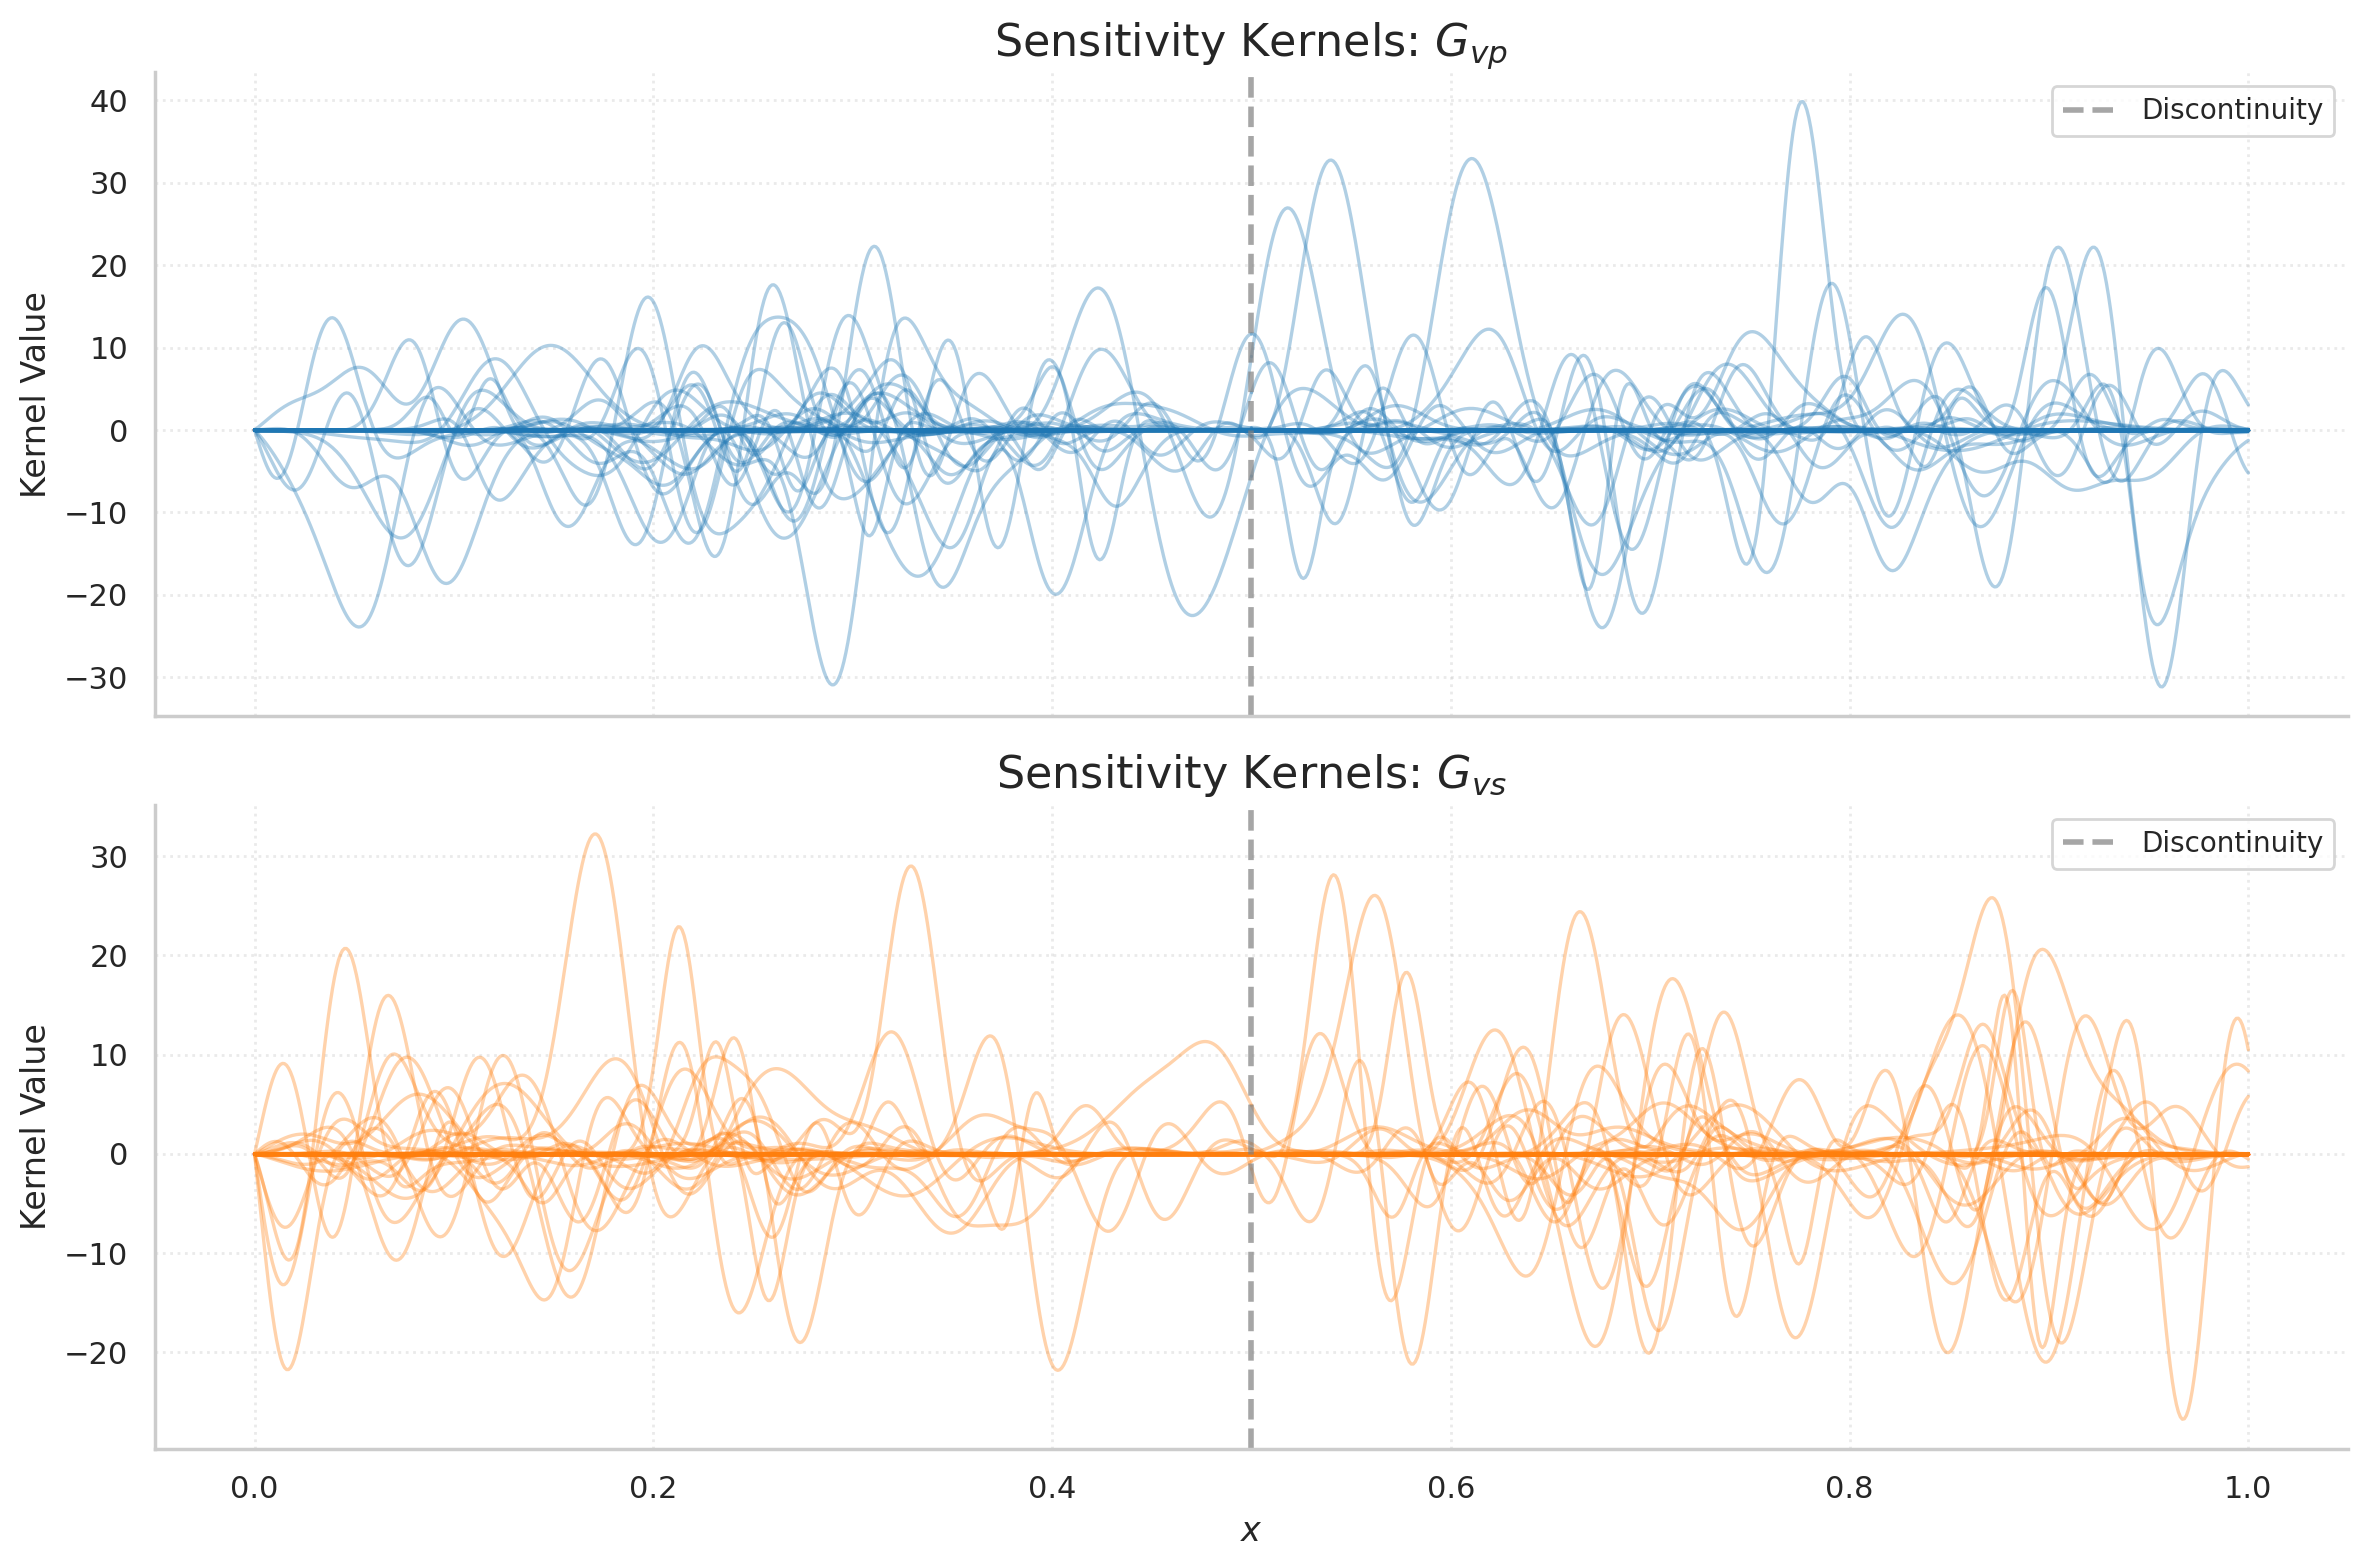

Sensitivity kernels plotted for both vp and vs components.
Each component has kernels on both sides of the discontinuity.


In [30]:
# Sensitivity Kernels figure with 2 stacked subplots (vp and vs)
fig_title = "Sensitivity Kernels (vp & vs)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

x = function_domain.uniform_mesh(1000)

import seaborn as sns
sns.set_theme(style="whitegrid", palette="muted", color_codes=True)

# Create two vertically stacked subplots: top for G_vp, bottom for G_vs
fig, axs = plt.subplots(2, 1, figsize=(12, 8), dpi=200, sharex=True)

# Create evaluation points for each subdomain
x_lower = M_vp.subspace(0).function_domain.uniform_mesh(500)
x_upper = M_vp.subspace(1).function_domain.uniform_mesh(500)

# ============================================================================
# TOP SUBPLOT: G_vp kernels (with discontinuity)
# ============================================================================
# G_vp is a RowLinearOperator with blocks [G_vp_lower, G_vp_upper]
G_vp_lower = G_vp.block(0, 0)  # Kernels on (0, 0.5) for vp
G_vp_upper = G_vp.block(0, 1)  # Kernels on (0.5, 1] for vp

# Plot kernels from lower subspace
for i in range(N_d):
    kernel_lower = G_vp_lower.get_kernel(i)
    axs[0].plot(
        x_lower,
        kernel_lower.evaluate(x_lower),
        color='tab:blue',
        alpha=0.35,
        linewidth=1.2
    )

# Plot kernels from upper subspace
for i in range(N_d):
    kernel_upper = G_vp_upper.get_kernel(i)
    axs[0].plot(
        x_upper,
        kernel_upper.evaluate(x_upper),
        color='tab:blue',
        alpha=0.35,
        linewidth=1.2
    )

# Add vertical line at discontinuity
axs[0].axvline(R_discontinuity, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Discontinuity')
axs[0].set_title(r"Sensitivity Kernels: $G_{vp}$", fontsize=16)
axs[0].set_ylabel("Kernel Value", fontsize=12)
axs[0].legend(fontsize=10, loc='best')
axs[0].grid(True, linestyle=':', alpha=0.4)

# ============================================================================
# BOTTOM SUBPLOT: G_vs kernels (with discontinuity)
# ============================================================================
# G_vs is a RowLinearOperator with blocks [G_vs_lower, G_vs_upper]
G_vs_lower = G_vs.block(0, 0)  # Kernels on (0, 0.5) for vs
G_vs_upper = G_vs.block(0, 1)  # Kernels on (0.5, 1] for vs

# Plot kernels from lower subspace
for i in range(N_d):
    kernel_lower = G_vs_lower.get_kernel(i)
    axs[1].plot(
        x_lower,
        kernel_lower.evaluate(x_lower),
        color='tab:orange',
        alpha=0.35,
        linewidth=1.2
    )

# Plot kernels from upper subspace
for i in range(N_d):
    kernel_upper = G_vs_upper.get_kernel(i)
    axs[1].plot(
        x_upper,
        kernel_upper.evaluate(x_upper),
        color='tab:orange',
        alpha=0.35,
        linewidth=1.2
    )

# Add vertical line at discontinuity
axs[1].axvline(R_discontinuity, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Discontinuity')
axs[1].set_title(r"Sensitivity Kernels: $G_{vs}$", fontsize=16)
axs[1].set_xlabel(r"$x$", fontsize=12)
axs[1].set_ylabel("Kernel Value", fontsize=12)
axs[1].legend(fontsize=10, loc='best')
axs[1].grid(True, linestyle=':', alpha=0.4)

sns.despine()
plt.tight_layout()

# Save as both PNG and PDF for publication
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

print("Sensitivity kernels plotted for both vp and vs components.")
print("Each component has kernels on both sides of the discontinuity.")


### Sensitivity Kernels Visualization

The sensitivity kernels $K_i(x)$ define how sensitive each data point $d_i$ is to the model $m(x)$ at different spatial locations. These kernels are crucial for understanding:

- **Coverage**: Where in the domain we have observational sensitivity
- **Resolution**: How localized our measurements are
- **Redundancy**: Overlapping kernels indicate multiple measurements of similar information

Regions where many kernels overlap (appearing darker) represent areas of high observational density, while sparse regions indicate limited sensitivity.

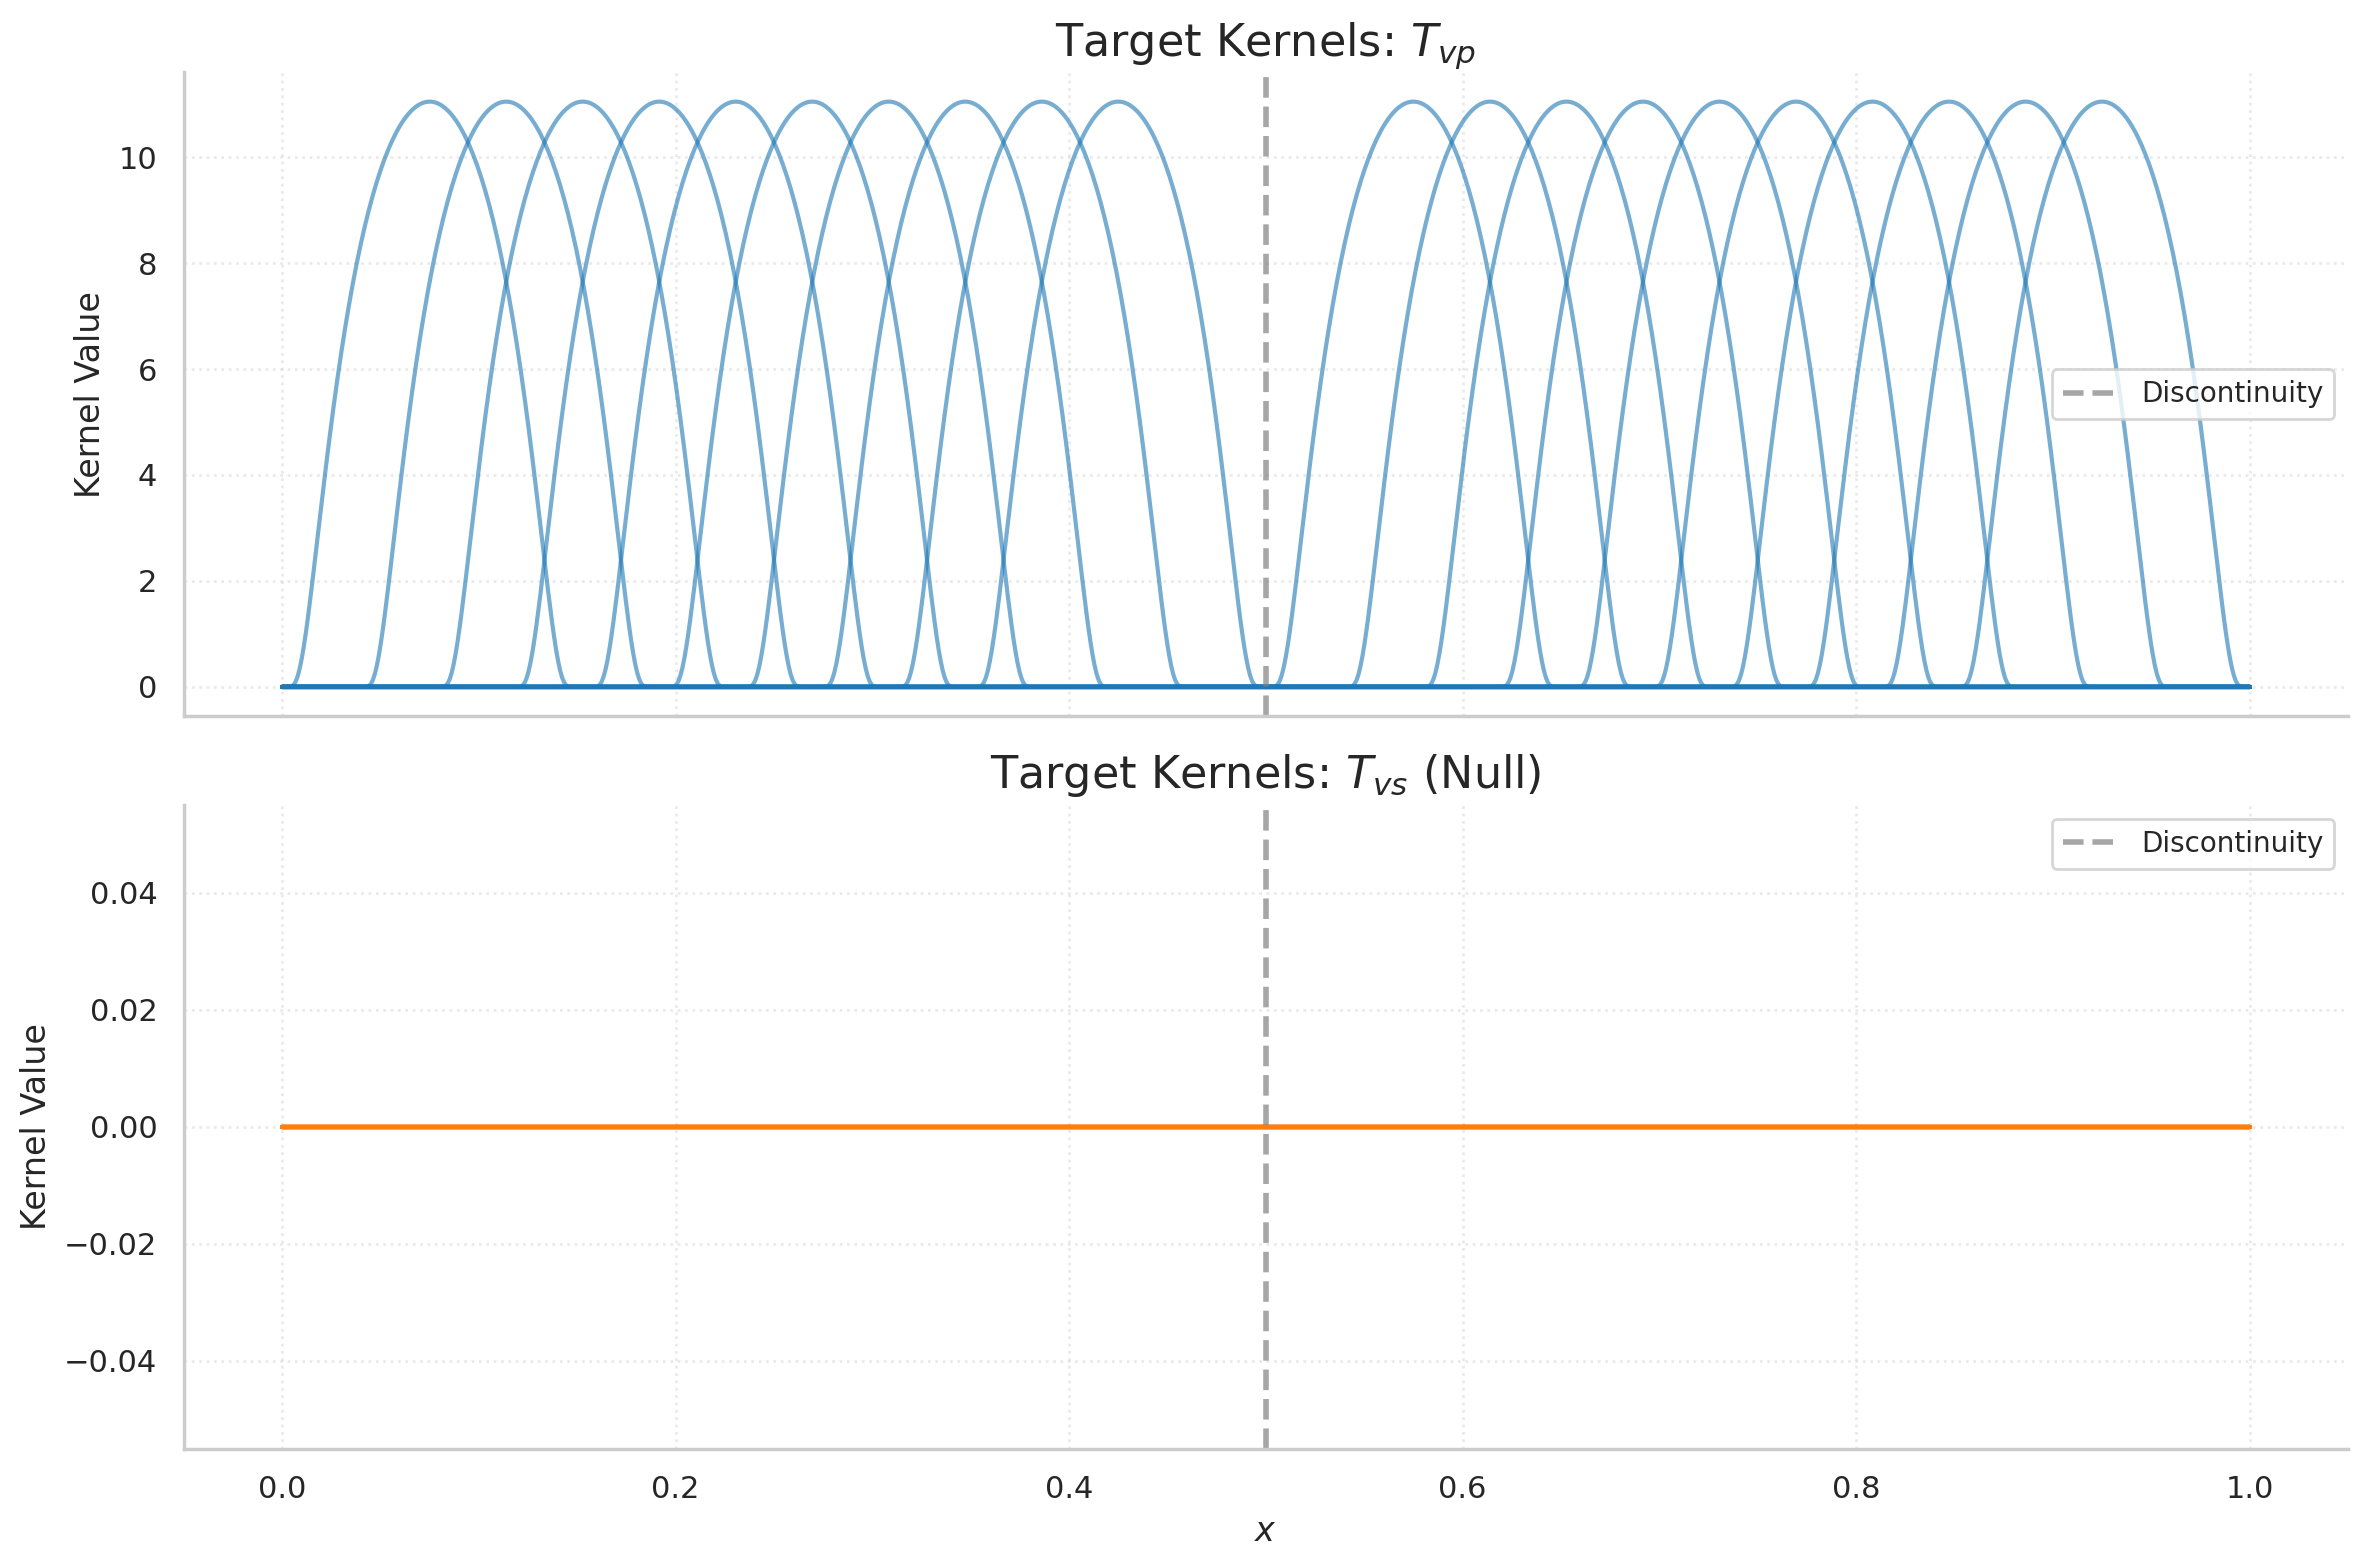

Note: T_vs kernels are null (zero) since we only target vp properties.


In [31]:
# Target Kernels figure with 2 stacked subplots (vp and vs)
fig_title = "Target Kernels (vp & vs)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

sns.set_theme(style="whitegrid", palette="muted", color_codes=True)

# Create two vertically stacked subplots: top for T_vp, bottom for T_vs
fig, axs = plt.subplots(2, 1, figsize=(12, 8), dpi=200, sharex=True)

# ============================================================================
# TOP SUBPLOT: T_vp kernels (with discontinuity)
# ============================================================================
# T_vp is a RowLinearOperator with blocks [T_vp_lower, T_vp_upper]
T_vp_lower = T_vp.block(0, 0)  # Kernels on (0, 0.5) for vp
T_vp_upper = T_vp.block(0, 1)  # Kernels on (0.5, 1] for vp

# Plot kernels from lower subspace
for i in range(N_p):
    kernel_lower = T_vp_lower.get_kernel(i)
    axs[0].plot(
        x_lower,
        kernel_lower.evaluate(x_lower),
        color='tab:blue',
        alpha=0.6,
        linewidth=1.5
    )

# Plot kernels from upper subspace
for i in range(N_p):
    kernel_upper = T_vp_upper.get_kernel(i)
    axs[0].plot(
        x_upper,
        kernel_upper.evaluate(x_upper),
        color='tab:blue',
        alpha=0.6,
        linewidth=1.5
    )

# Add vertical line at discontinuity
axs[0].axvline(R_discontinuity, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Discontinuity')
axs[0].set_title(r"Target Kernels: $T_{vp}$", fontsize=16)
axs[0].set_ylabel("Kernel Value", fontsize=12)
axs[0].legend(fontsize=10, loc='best')
axs[0].grid(True, linestyle=':', alpha=0.4)

# ============================================================================
# BOTTOM SUBPLOT: T_vs kernels (with discontinuity - should be zeros)
# ============================================================================
# T_vs is a RowLinearOperator with blocks [T_vs_lower, T_vs_upper]
# Since we use NullFunctionProvider, these should all be zero
T_vs_lower = T_vs.block(0, 0)  # Kernels on (0, 0.5) for vs
T_vs_upper = T_vs.block(0, 1)  # Kernels on (0.5, 1] for vs

# Plot kernels from lower subspace
for i in range(N_p):
    kernel_lower = T_vs_lower.get_kernel(i)
    axs[1].plot(
        x_lower,
        kernel_lower.evaluate(x_lower),
        color='tab:orange',
        alpha=0.6,
        linewidth=1.5
    )

# Plot kernels from upper subspace
for i in range(N_p):
    kernel_upper = T_vs_upper.get_kernel(i)
    axs[1].plot(
        x_upper,
        kernel_upper.evaluate(x_upper),
        color='tab:orange',
        alpha=0.6,
        linewidth=1.5
    )

# Add vertical line at discontinuity
axs[1].axvline(R_discontinuity, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Discontinuity')
axs[1].set_title(r"Target Kernels: $T_{vs}$ (Null)", fontsize=16)
axs[1].set_xlabel(r"$x$", fontsize=12)
axs[1].set_ylabel("Kernel Value", fontsize=12)
axs[1].legend(fontsize=10, loc='best')
axs[1].grid(True, linestyle=':', alpha=0.4)

sns.despine()
plt.tight_layout()

# Save as both PNG and PDF
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

print("Note: T_vs kernels are null (zero) since we only target vp properties.")


### Target Kernels for Property Extraction

The target kernels $T_i(x)$ define the properties we want to infer about the model. Each kernel extracts a local average of the model around its center location. 

**Critical Design Consideration for Discontinuous Spaces**: Target kernels must have **compact support entirely within each subdomain**. If a kernel's support crosses the discontinuity boundary at $x = 0.5$:
- The kernel gets clipped when restricted to each subdomain
- This can cause unexpected behavior and reduced accuracy

**Our Solution**: We design target kernels in two groups:
- **Lower subdomain** $(0, 0.5)$: Kernels centered and supported entirely within this interval
- **Upper subdomain** $(0.5, 1]$: Kernels centered and supported entirely within this interval

This ensures that when the kernels are restricted to their respective subdomains via the `SOLAOperator.for_direct_sum()` mechanism, they remain well-defined and properly localized.

These bump functions allow us to:
- **Localize**: Extract spatially localized properties within each subdomain
- **Regularize**: Smooth local estimates through spatial averaging  
- **Focus**: Target specific regions of interest while respecting the discontinuity structure


## Synthetic Data Generation

### True Model Construction

We create a synthetic "true" model $\bar{m}(x)$ that combines multiple scales of variation:

$$\bar{m}(x) = \exp\left(-\frac{(x - 0.5)^2}{0.5^2}\right) \sin(5\pi x) + x$$

This model includes:
- **Global trend**: Linear component $x$ 
- **Localized oscillation**: Gaussian-windowed sine wave for fine-scale structure
- **Smooth envelope**: Exponential decay for spatial localization

From this true model, we generate synthetic observations $\mathbf{\bar{d}} = G(\bar{m})$ and add noise to create realistic measurements $\mathbf{\tilde{d}}$.

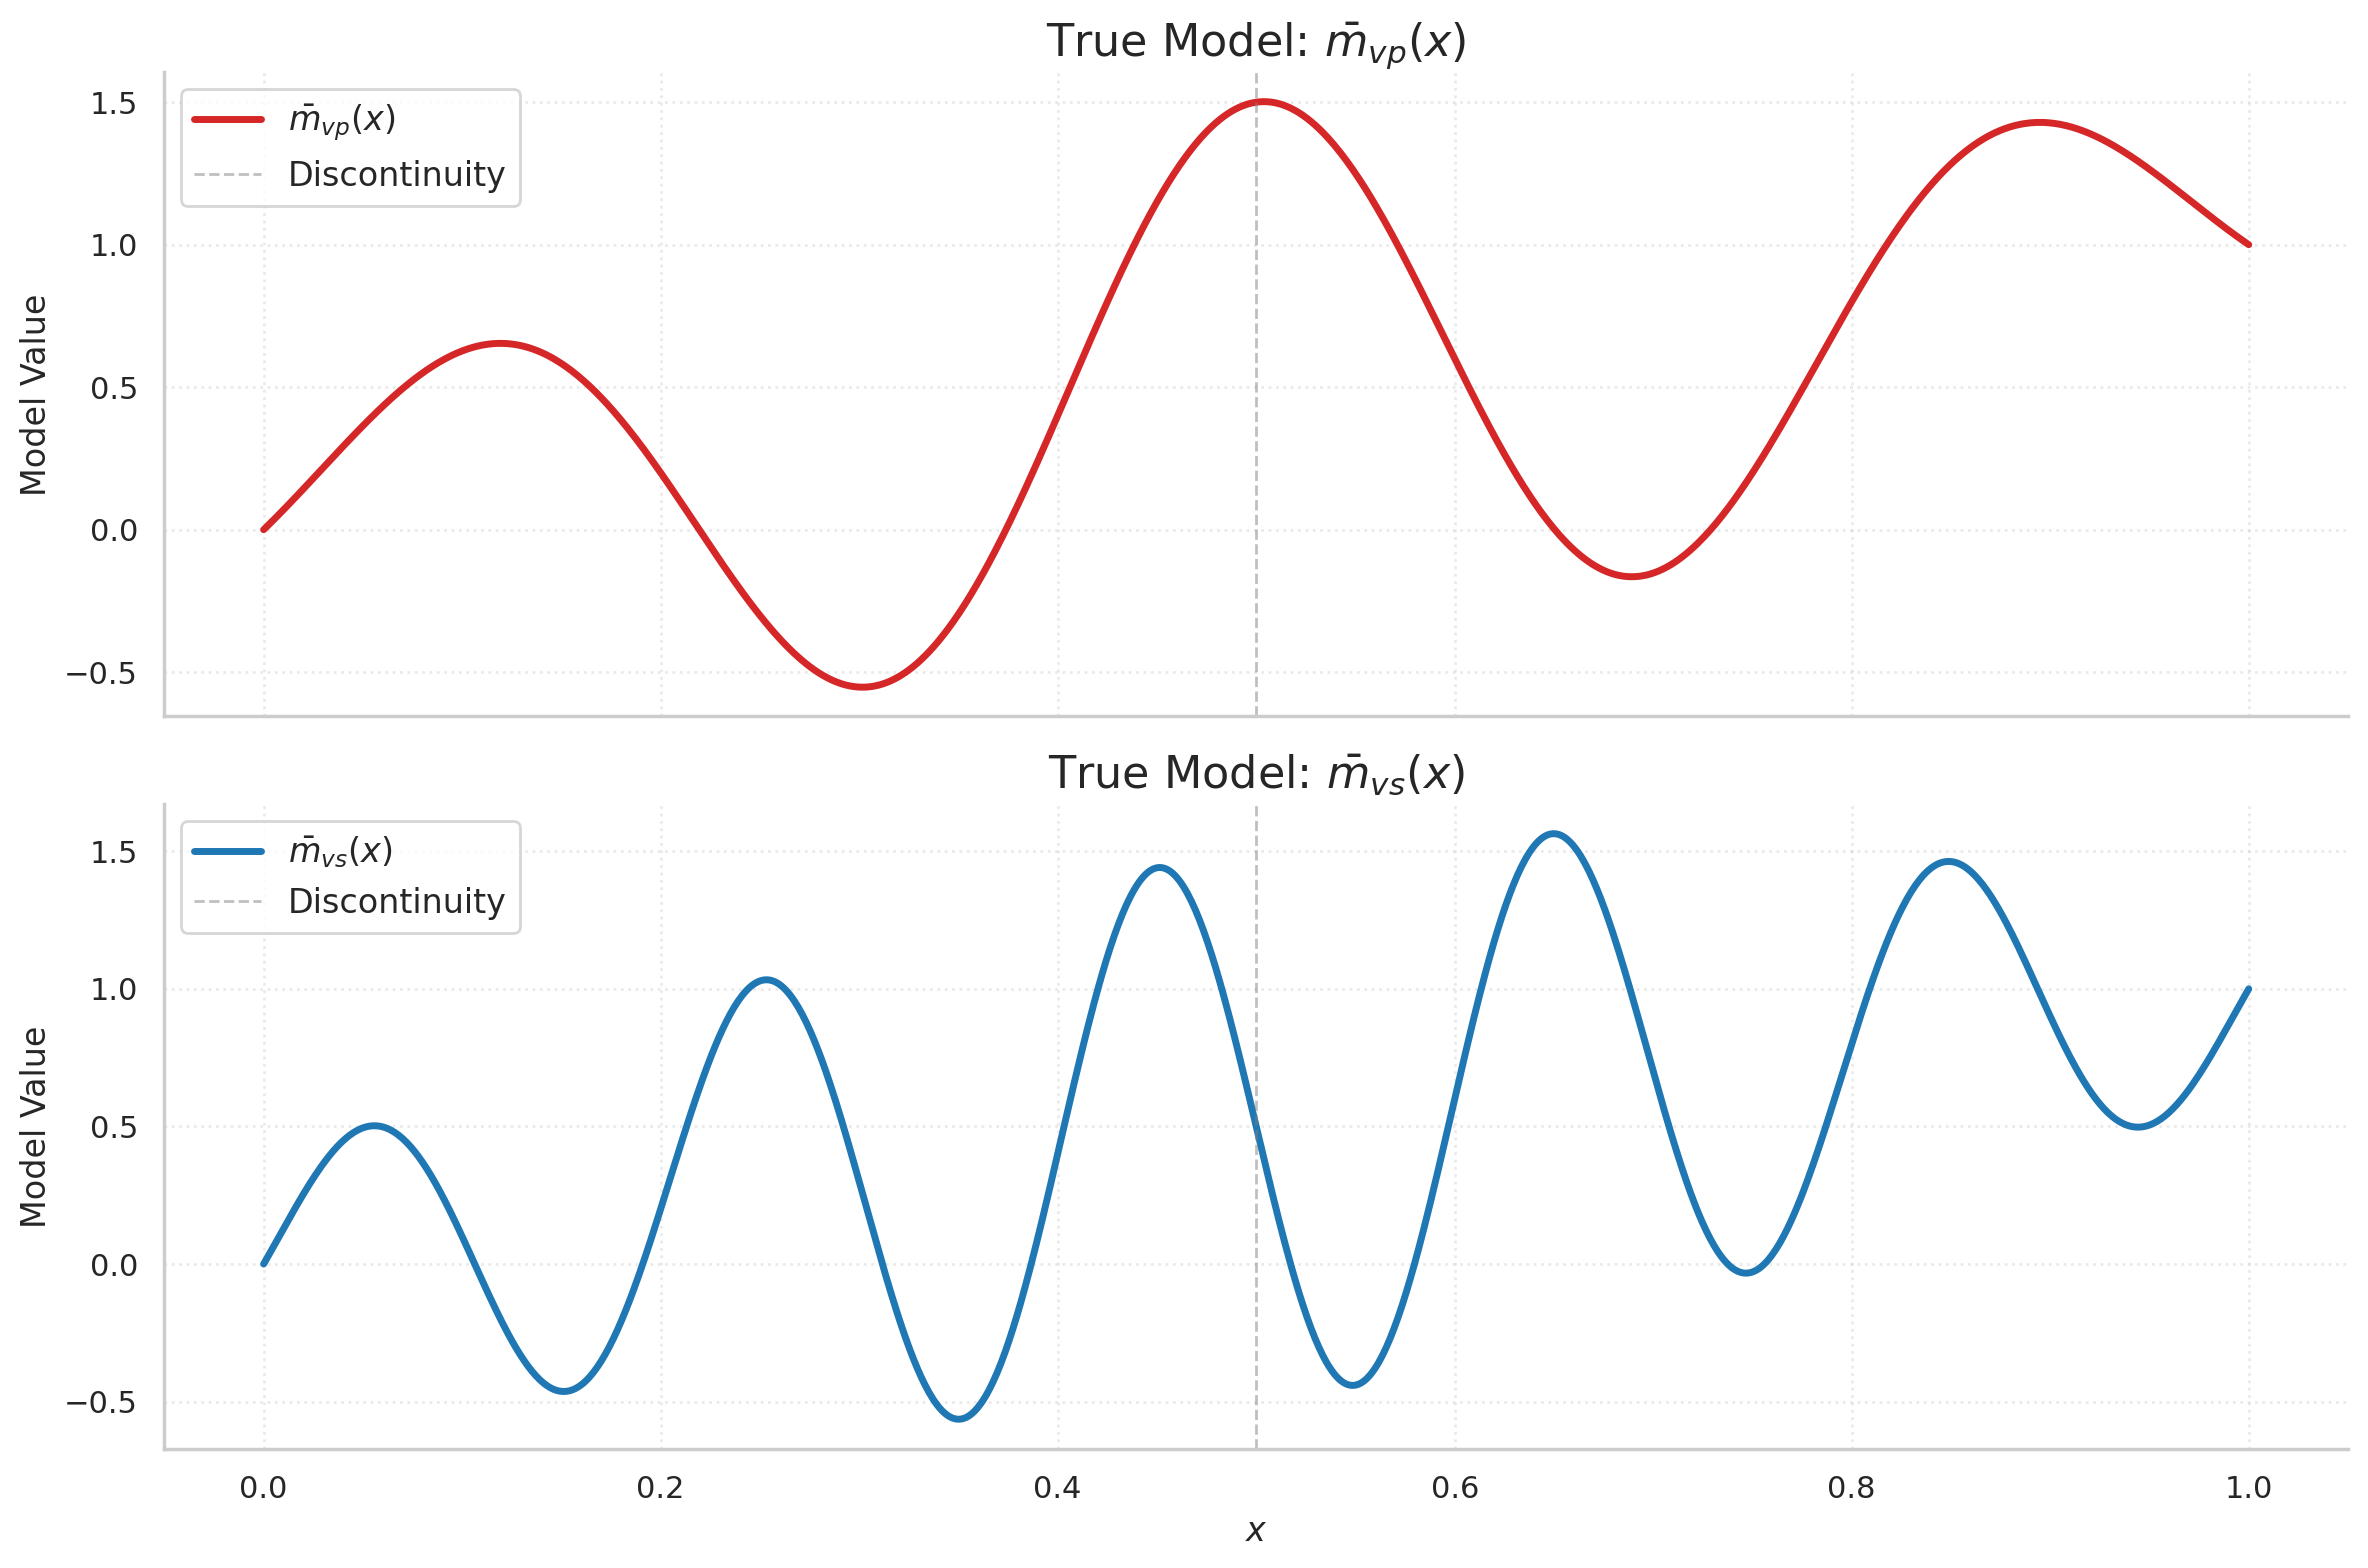

Generating synthetic data...
Signal-to-noise ratio: 10.0
Number of observations: 100
Signal-to-noise ratio: 10.0
Number of observations: 100


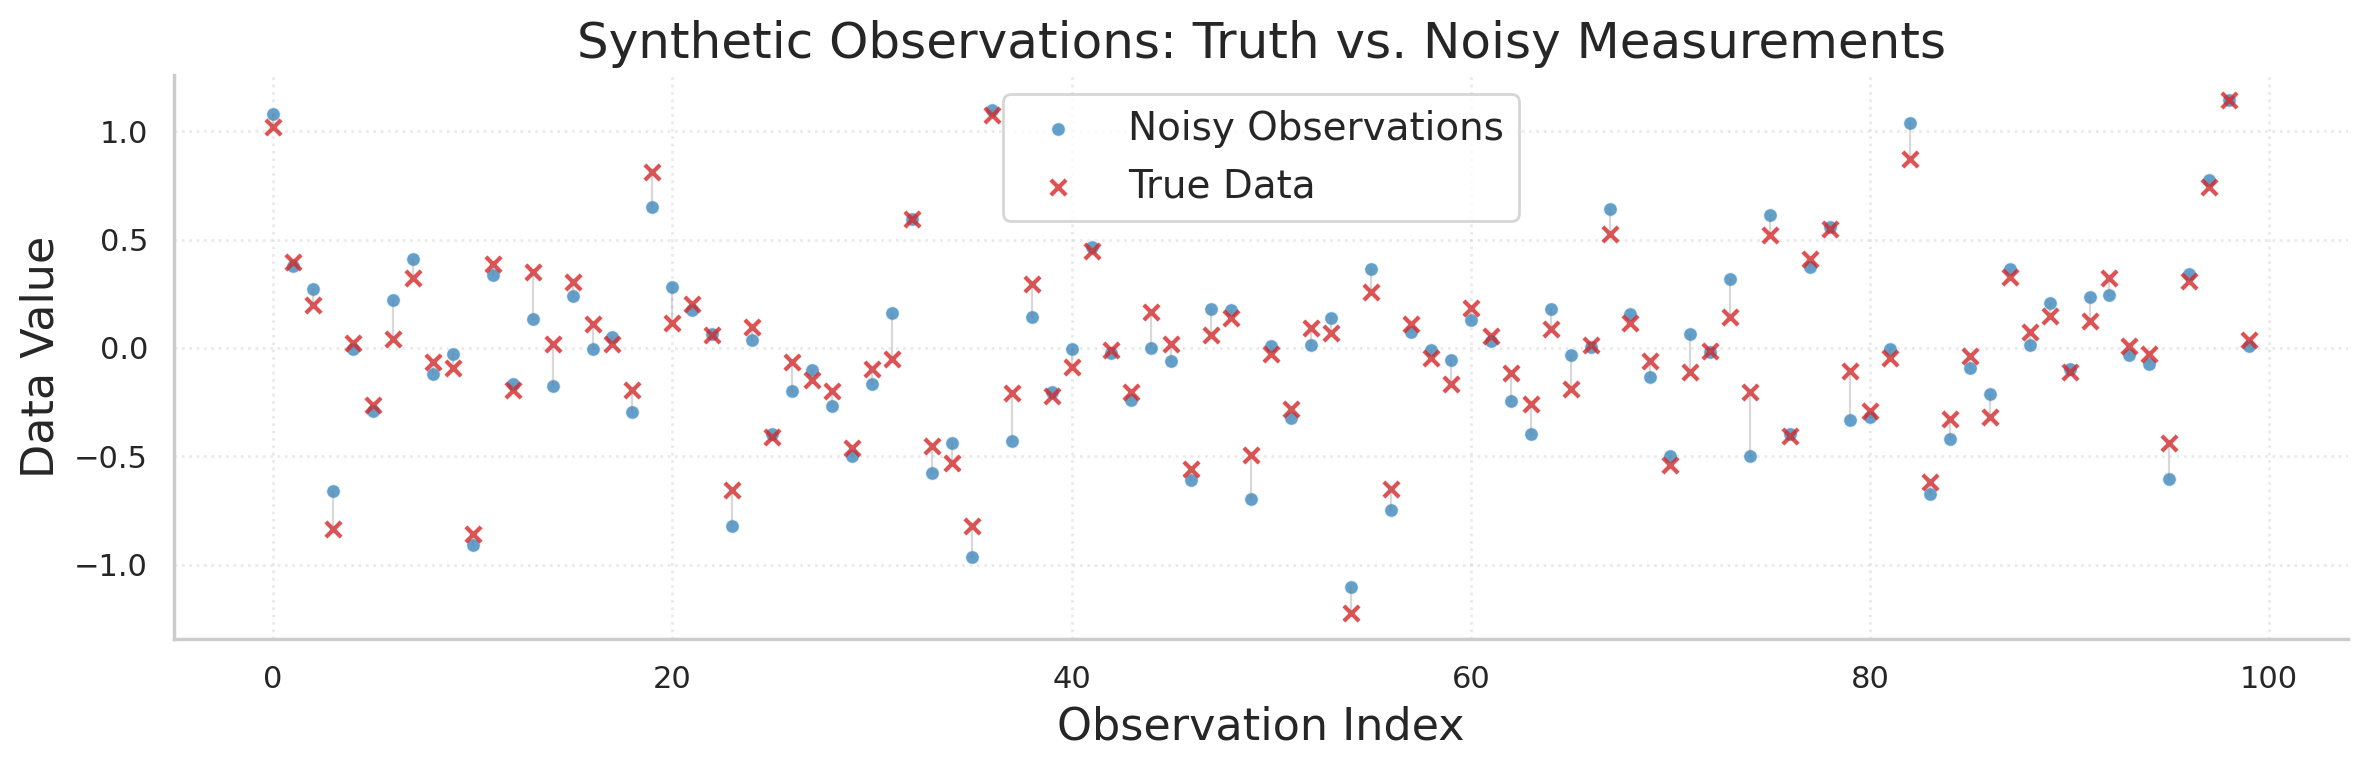

In [32]:
# Create synthetic true models for vp and vs as discontinuous functions
# Define the true model callables
def true_model_callable_vp(x):
    return np.exp(-((x - function_domain.center)/0.5)**2) * np.sin(5 * np.pi * x) + x

def true_model_callable_vs(x):
    return np.exp(-((x - function_domain.center)/0.5)**2) * np.sin(10 * np.pi * x) + x

# Create functions on each subspace for vp
m_bar_vp_lower = Function(M_vp.subspace(0), evaluate_callable=true_model_callable_vp)
m_bar_vp_upper = Function(M_vp.subspace(1), evaluate_callable=true_model_callable_vp)
m_bar_vp = [m_bar_vp_lower, m_bar_vp_upper]  # Discontinuous vp

# Create functions on each subspace for vs
m_bar_vs_lower = Function(M_vs.subspace(0), evaluate_callable=true_model_callable_vs)
m_bar_vs_upper = Function(M_vs.subspace(1), evaluate_callable=true_model_callable_vs)
m_bar_vs = [m_bar_vs_lower, m_bar_vs_upper]  # Discontinuous vs

# Combine into full model list [vp, vs] where each is [lower, upper]
m_bar = [m_bar_vp, m_bar_vs]

# For visualization, create continuous versions on the full domain
M_full_vp = Lebesgue(N, function_domain, basis=None)
M_full_vs = Lebesgue(N, function_domain, basis=None)
m_bar_vp_full = Function(M_full_vp, evaluate_callable=true_model_callable_vp)
m_bar_vs_full = Function(M_full_vs, evaluate_callable=true_model_callable_vs)

# True model plots: two stacked subplots (vp on top, vs on bottom)
fig_title = "True Models (vp & vs)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

sns.set_theme(style="whitegrid", palette="muted", color_codes=True)
fig, axs = plt.subplots(2, 1, figsize=(12, 8), dpi=200, sharex=True)

# Top: vp
axs[0].plot(x, m_bar_vp_full.evaluate(x), color='tab:red', linewidth=2.5, label=r'$\bar{m}_{vp}(x)$')
axs[0].axvline(R_discontinuity, color='gray', linestyle='--', alpha=0.5, linewidth=1, label='Discontinuity')
axs[0].set_title(r"True Model: $\bar{m}_{vp}(x)$", fontsize=16)
axs[0].set_ylabel('Model Value', fontsize=12)
axs[0].legend(fontsize=12)
axs[0].grid(True, linestyle=':', alpha=0.4)

# Bottom: vs
axs[1].plot(x, m_bar_vs_full.evaluate(x), color='tab:blue', linewidth=2.5, label=r'$\bar{m}_{vs}(x)$')
axs[1].axvline(R_discontinuity, color='gray', linestyle='--', alpha=0.5, linewidth=1, label='Discontinuity')
axs[1].set_title(r"True Model: $\bar{m}_{vs}(x)$", fontsize=16)
axs[1].set_xlabel(r"$x$", fontsize=12)
axs[1].set_ylabel('Model Value', fontsize=12)
axs[1].legend(fontsize=12)
axs[1].grid(True, linestyle=':', alpha=0.4)

sns.despine()
plt.tight_layout()

# Save
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Generate synthetic observations
print("Generating synthetic data...")
d_bar = G(m_bar)  # Clean observations - G expects [[vp_lower, vp_upper], [vs_lower, vs_upper]]
noise_level = 0.1 * np.max(d_bar)
np.random.seed(42)  # For reproducibility
d_tilde = d_bar + np.random.normal(0, noise_level, d_bar.shape)  # Noisy observations

print(f"Signal-to-noise ratio: {np.max(d_bar) / noise_level:.1f}")
print(f"Number of observations: {len(d_tilde)}")

# Publication-quality data comparison plot
fig_title = "Synthetic Observations"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
data_indices = np.arange(len(d_bar))

# Plot connection lines between true and noisy data
for i in range(len(d_bar)):
    plt.plot([i, i], [d_bar[i], d_tilde[i]], color='gray', alpha=0.3, linewidth=0.8)

# Plot the data points
plt.scatter(data_indices, d_tilde, label='Noisy Observations',
           color='tab:blue', alpha=0.7, marker='o', s=25, edgecolors='white', linewidths=0.5)
plt.scatter(data_indices, d_bar, label='True Data',
           color='tab:red', alpha=0.8, marker='x', s=30, linewidths=1.5)

plt.xlabel('Observation Index', fontsize=16)
plt.ylabel('Data Value', fontsize=16)
plt.title('Synthetic Observations: Truth vs. Noisy Measurements', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()


## Bayesian Setup: Data and Prior Measures

### Data Noise Model

We model the measurement noise as independent Gaussian with known variance:
$$\mathbf{\eta} \sim \mathcal{N}(\mathbf{0}, \mathbf{C}_{\mathcal{D}})$$

where $\mathbf{C}_{\mathcal{D}} = \sigma^2 \mathbf{I}$ represents uncorrelated measurement errors. This gives us the data likelihood:
$$\mathbf{\tilde{d}} | m \sim \mathcal{N}(G(m), \mathbf{C}_{\mathcal{D}})$$

**Important distinction**: 
- **Data error measure**: $\mathcal{N}(\mathbf{0}, \mathbf{C}_{\mathcal{D}})$ - represents the noise model for `LinearForwardProblem`
- **Data measure**: $\mathcal{N}(\mathbf{\tilde{d}}, \mathbf{C}_{\mathcal{D}})$ - represents the observed data for visualization

In [33]:
# Define data noise covariance
noise_variance = (0.1 * np.max(d_tilde))**2  # 10% of peak signal
C_D_matrix = noise_variance * np.eye(N_d)

print(f"Data noise standard deviation: {np.sqrt(noise_variance):.4f}")
print(f"Relative noise level: {100 * np.sqrt(noise_variance) / np.max(d_tilde):.1f}%")

# Create data NOISE measure (zero mean) for LinearForwardProblem
# This represents the noise model: η ~ N(0, C_D)
gaussian_D_noise = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=np.zeros(N_d))

# Create data measure (with observed data mean) for visualization
# This represents the likelihood: d̃ | m ~ N(G(m), C_D)
gaussian_D = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=d_tilde)

Data noise standard deviation: 0.1143
Relative noise level: 10.0%


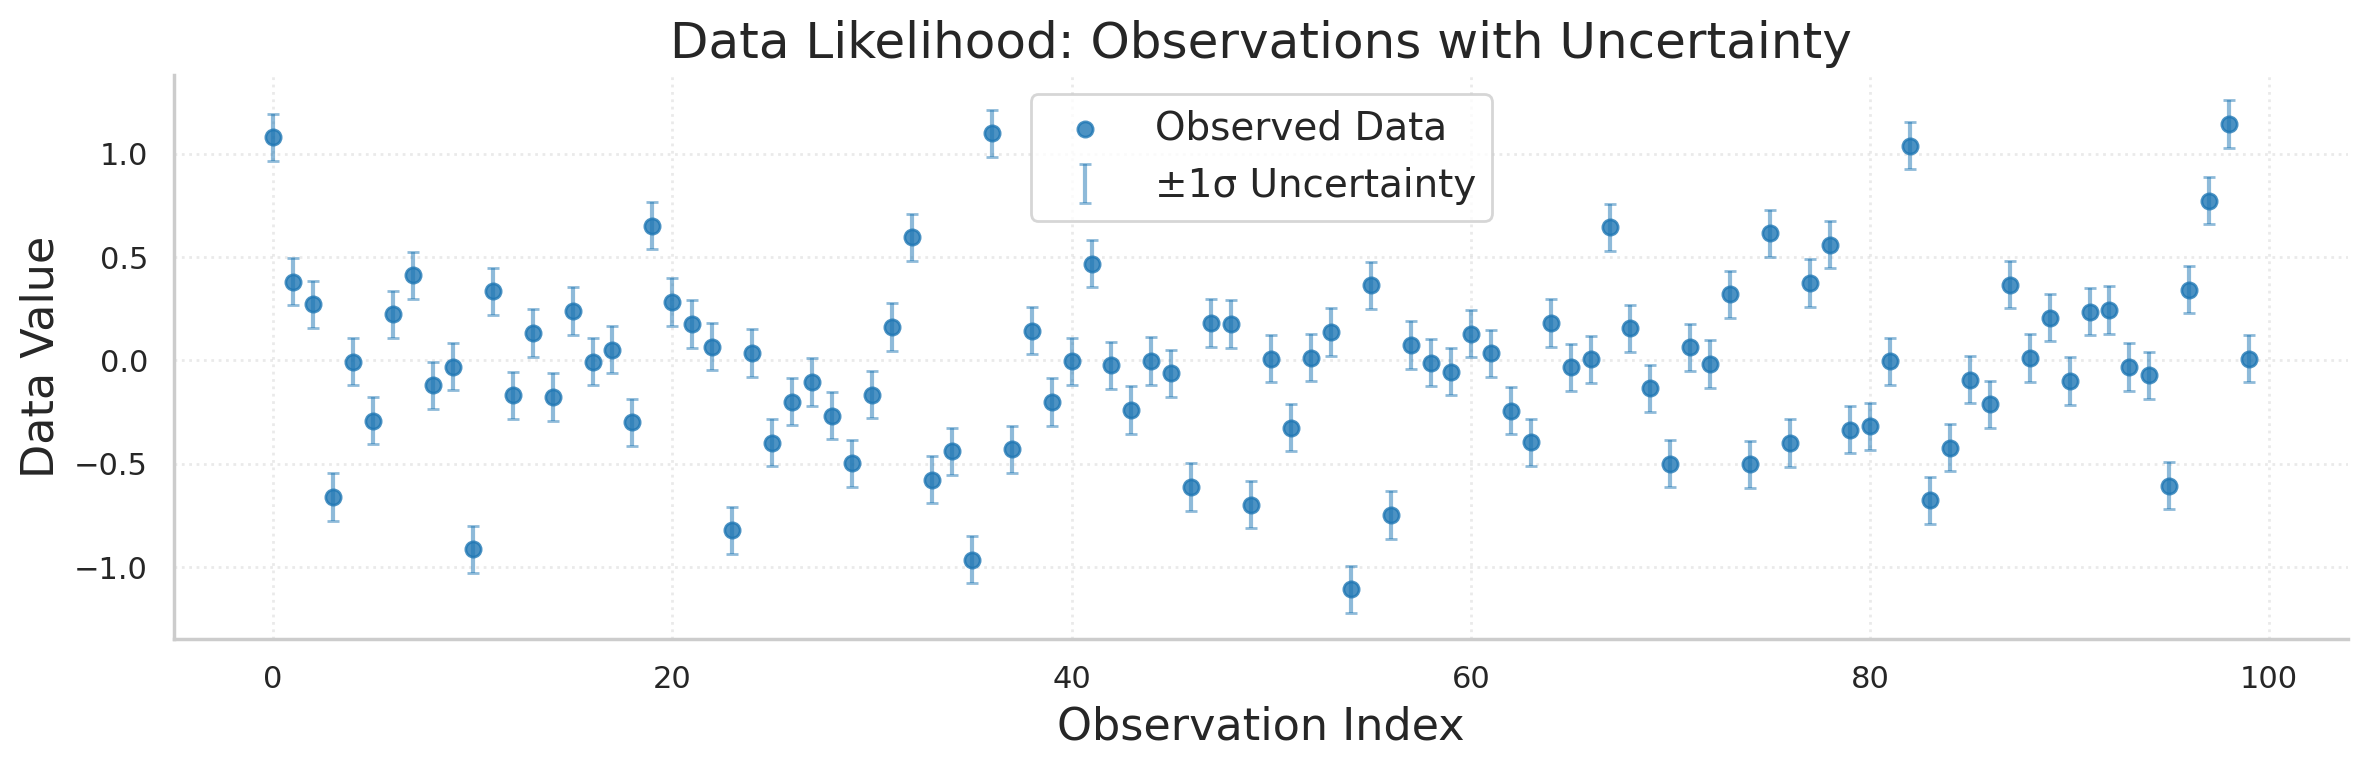

In [34]:
# Visualize the data measure (observed data with uncertainty)
# Note: We use gaussian_D (with data mean) for visualization, not gaussian_D_error (zero mean)
mean_values = gaussian_D.expectation
std_values = np.sqrt(noise_variance)

fig_title = "Data Likelihood Distribution"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
data_indices = np.arange(len(mean_values))

plt.scatter(data_indices, mean_values, label='Observed Data', color='tab:blue', alpha=0.8, s=30)
plt.errorbar(data_indices, mean_values, yerr=std_values, fmt='none',
            color='tab:blue', alpha=0.5, capsize=2, capthick=1,
            label='±1σ Uncertainty')

plt.title("Data Likelihood: Observations with Uncertainty", fontsize=18)
plt.xlabel('Observation Index', fontsize=16)
plt.ylabel('Data Value', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

### Prior Model

We assign a Gaussian prior measure to regularize the inverse problem:
$$m \sim \mu_{\mathcal{M}}^0 = \mathcal{N}(m_0, C_0)$$

**Prior Mean**: $m_0(x) = x$ (simple linear trend)

**Prior Covariance**: We use the inverse of a scaled Laplacian operator:
$$C_0 = (-\alpha \Delta)^{-1}$$

where $\alpha > 0$ controls the correlation length scale. This choice:
- Enforces smooth realizations (derivatives are penalized)
- Has explicit eigenfunction expansion using sine basis
- Provides fast sampling via Karhunen-Loève expansion

In [35]:
from pygeoinf.interval.operators import Laplacian, BesselSobolevInverse
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.direct_sum import BlockDiagonalLinearOperator
from pygeoinf.gaussian_measure import GaussianMeasure
from pygeoinf.interval.KL_sampler import KLSampler

# Boundary conditions for each subspace (2 for vp, 2 for vs)
bcs = [BoundaryConditions(bc_type='neumann'),  # vp lower
       BoundaryConditions(bc_type='neumann'),  # vp upper
       BoundaryConditions(bc_type='neumann'),  # vs lower
       BoundaryConditions(bc_type='neumann')]  # vs upper

alpha = 0.1  # Amplifier -> the bigger -> the smoother
k, s = 1, 4  # Smoothness parameters for Bessel-Sobolev
dofs = 100

# Create Laplacian and covariance operators for each subspace
# M has 4 subspaces: [M_vp_lower, M_vp_upper, M_vs_lower, M_vs_upper]
laplacians = []
covariances = []
for i in range(M.number_of_subspaces):
    subspace = M.subspace(i)
    subspace_laplacians = []
    subspace_covariances = []
    for j in range(subspace.number_of_subspaces):
        subsubspace = subspace.subspace(j)
        L_sub = Laplacian(subsubspace, bcs[i], alpha, method='spectral', dofs=dofs)
        C_0_sub = BesselSobolevInverse(
            subsubspace, subsubspace, k, s, L_sub,
            dofs=dofs, n_samples=2048
        )
        subspace_laplacians.append(L_sub)
        subspace_covariances.append(C_0_sub)
    L_subspace = BlockDiagonalLinearOperator(subspace_laplacians)
    C_0_subspace = BlockDiagonalLinearOperator(subspace_covariances)
    laplacians.append(L_subspace)
    covariances.append(C_0_subspace)

# Create block diagonal operators
L = BlockDiagonalLinearOperator(laplacians)
C_0 = BlockDiagonalLinearOperator(covariances)

# Prior means for each subspace
# For vp: m_0(x) = x, for vs: m_0(x) = sin(x)
m_0_vp_lower = Function(M.subspace(0).subspace(0), evaluate_callable=lambda x: x)
m_0_vp_upper = Function(M.subspace(0).subspace(1), evaluate_callable=lambda x: x)
m_0_vs_lower = Function(M.subspace(1).subspace(0), evaluate_callable=lambda x: np.sin(x))
m_0_vs_upper = Function(M.subspace(1).subspace(1), evaluate_callable=lambda x: np.sin(x))
m_0 = [[m_0_vp_lower, m_0_vp_upper], [m_0_vs_lower, m_0_vs_upper]]

print(f"Prior covariance: Block diagonal (-{alpha}Δ)⁻¹ with Neumann boundary conditions")
print(f"Prior mean: m₀_vp(x) = x, m₀_vs(x) = sin(x) on each subspace")
print(f"Number of subspaces: {M.number_of_subspaces}")

# Set up Karhunen-Loève expansion for efficient sampling
# Create separate samplers for each sub-subspace
K = 100  # Number of KL terms (should be ≥ N for full representation)
print(f"Using {K} Karhunen-Loève terms for prior sampling")

# M has structure: [[vp_lower, vp_upper], [vs_lower, vs_upper]]
# covariances has structure: [[C_vp_lower, C_vp_upper], [C_vs_lower, C_vs_upper]]
# m_0 has structure: [[m_0_vp_lower, m_0_vp_upper], [m_0_vs_lower, m_0_vs_upper]]
samplers = []
for i, subcovariance in enumerate(covariances):  # Loop over vp and vs
    subsamplers = []
    for j, subsubcovariance in enumerate(subcovariance._operators):  # Loop over lower and upper
        sampler_sub = KLSampler(subsubcovariance, mean=m_0[i][j], n_modes=K)
        subsamplers.append(sampler_sub)
    samplers.append(subsamplers)

# Create sampling function that draws from each subspace independently
def sample_discontinuous():
    """Draw a sample from the prior on the discontinuous space.
    Returns [[vp_lower, vp_upper], [vs_lower, vs_upper]]
    """
    samples = []
    for sampler_group in samplers:
        subspace_samples = []
        for subsampler in sampler_group:
            sample = subsampler.sample()
            subspace_samples.append(sample)
        samples.append(subspace_samples)
    return samples

# Create Gaussian measure on model space
M_prior = GaussianMeasure(covariance=C_0, expectation=m_0, sample=sample_discontinuous)



Prior covariance: Block diagonal (-0.1Δ)⁻¹ with Neumann boundary conditions
Prior mean: m₀_vp(x) = x, m₀_vs(x) = sin(x) on each subspace
Number of subspaces: 2
Using 100 Karhunen-Loève terms for prior sampling


### Prior Measure Visualization

The Gaussian prior encodes our beliefs about the model before seeing data. We can visualize this through:
- **Samples**: Random realizations from the prior
- **Mean**: Expected model structure  
- **Uncertainty**: Point-wise standard deviation showing prior variability

Drawing samples from prior measure...


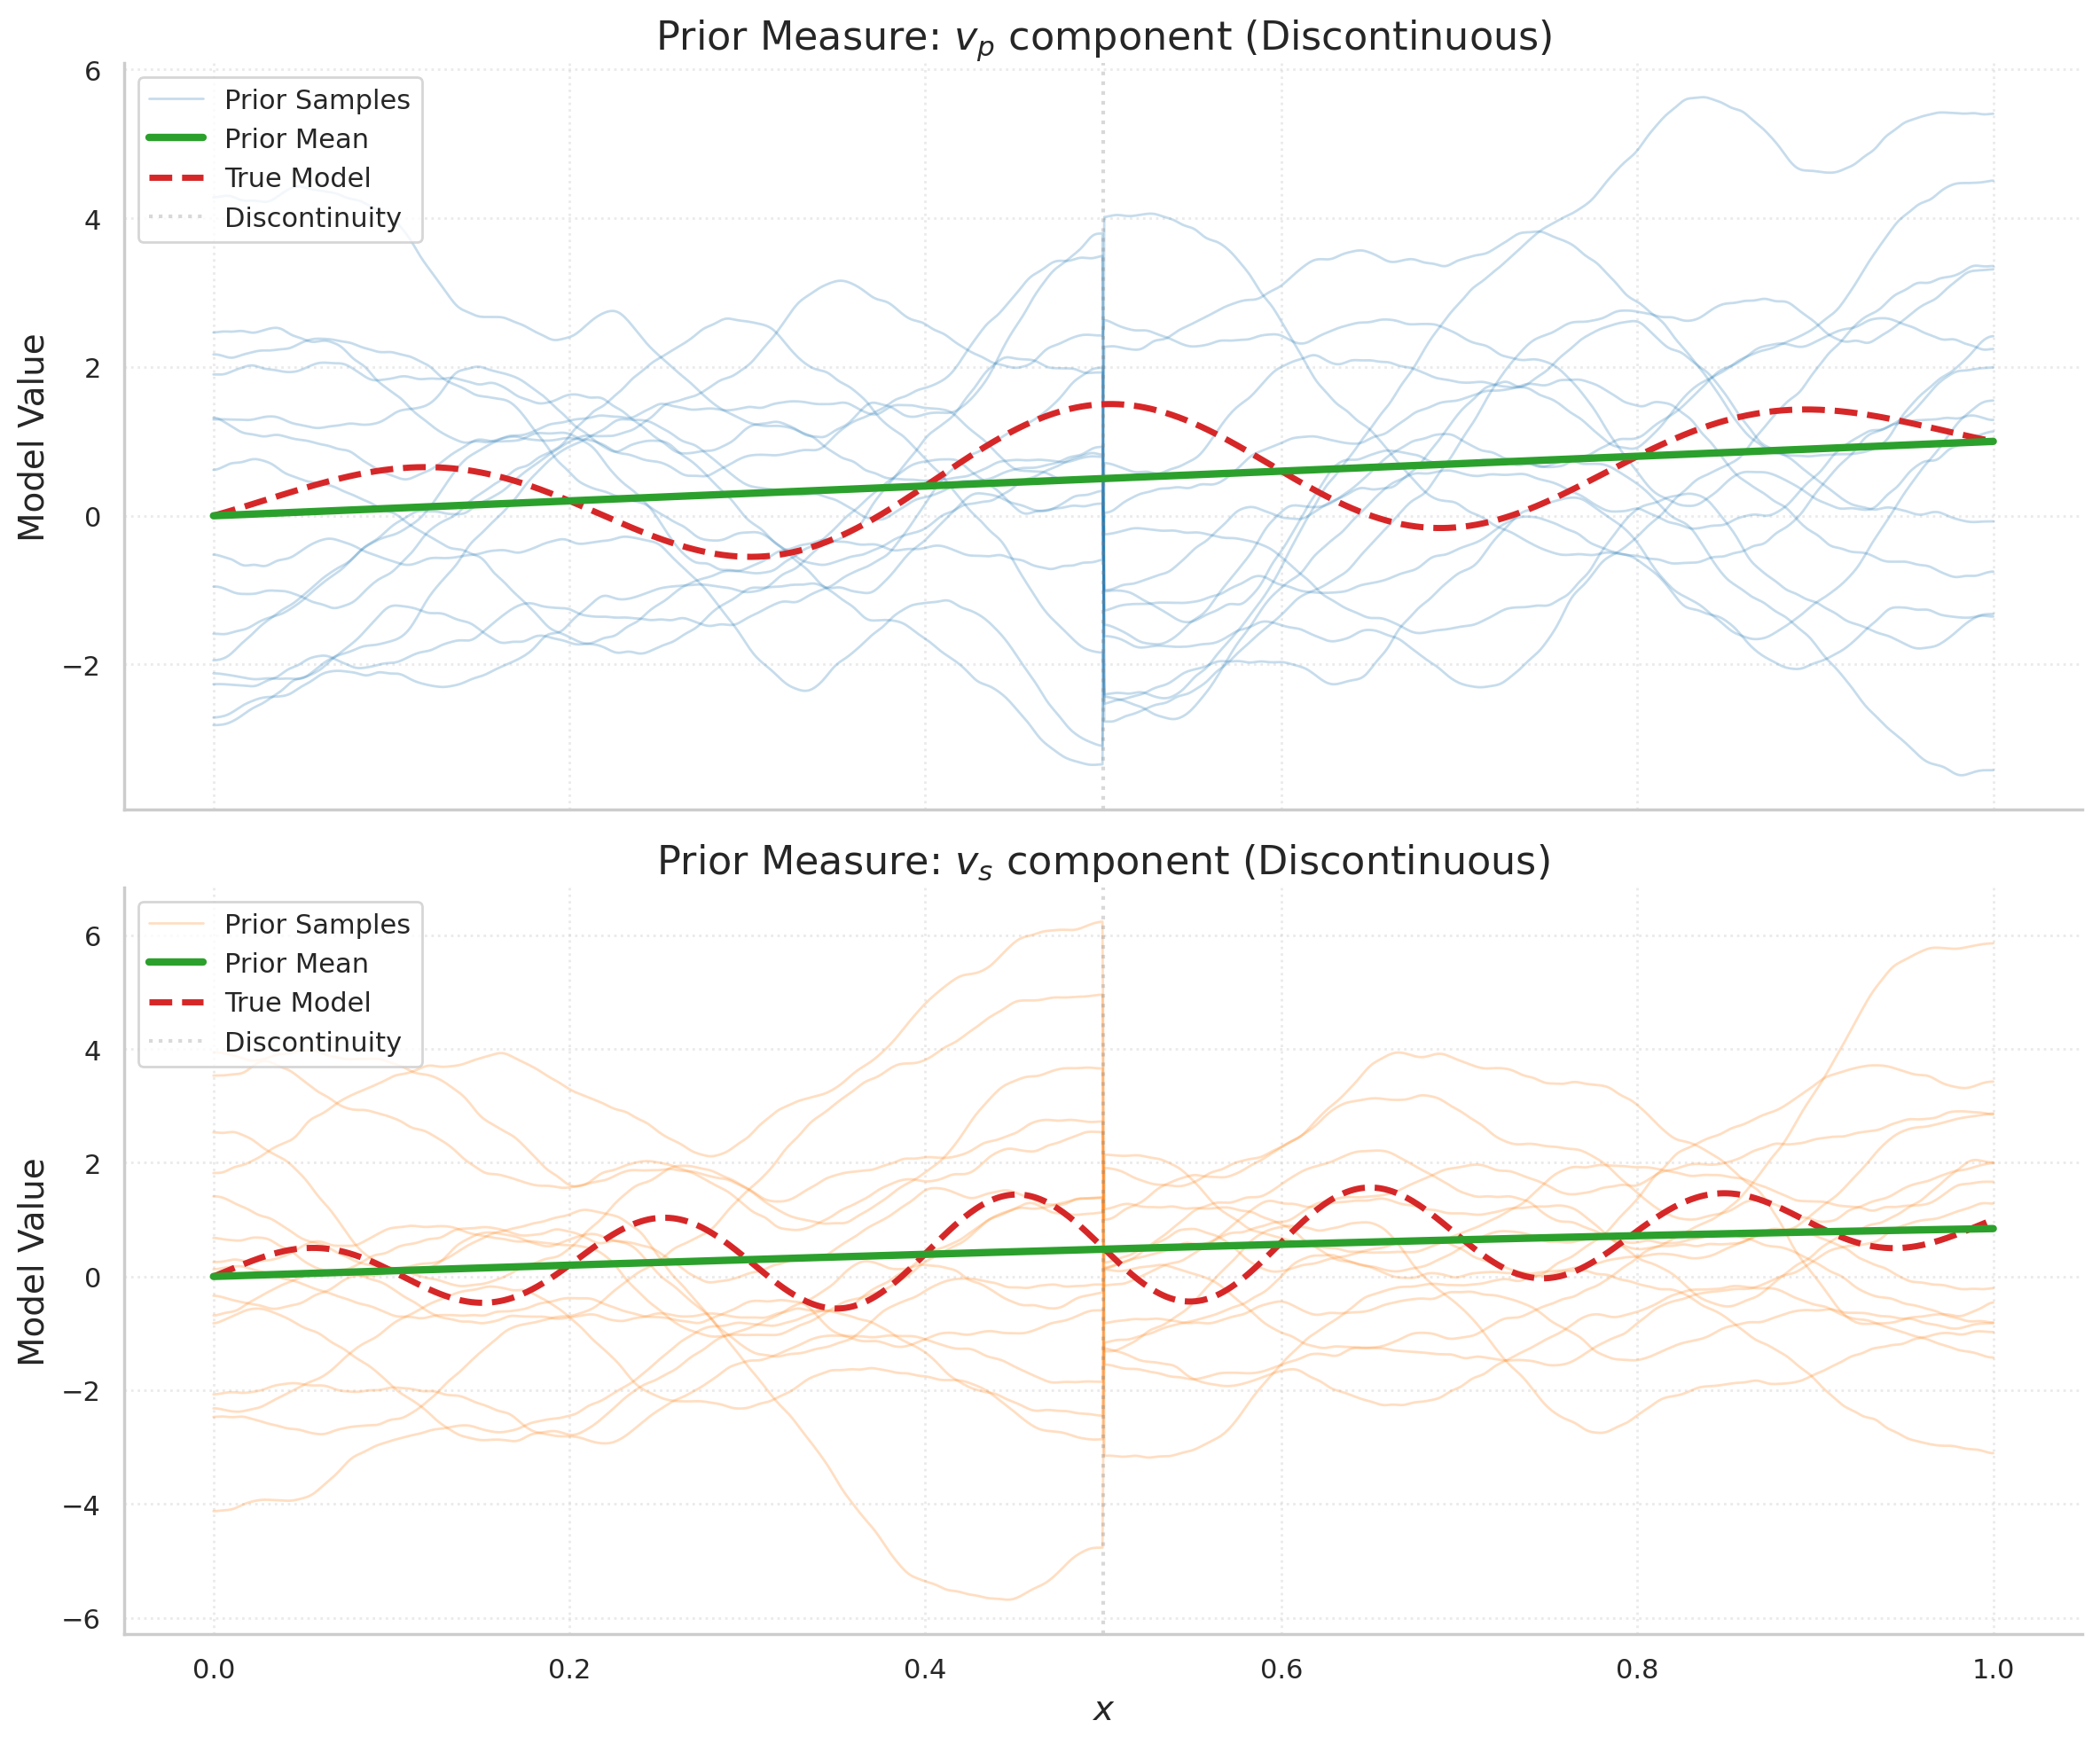


Note: Prior is independent on each subspace (block diagonal covariance)
Both vp and vs have discontinuities at x = 0.5


In [36]:
# Visualize the prior measure (two stacked subplots for vp and vs)
fig_title = "Prior Measure on Model Space (vp & vs with Discontinuities)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

# Parameters for visualization
num_samples = 15
sample_color_vp = 'tab:blue'
sample_color_vs = 'tab:orange'
mean_color = 'tab:green'

# Create two vertically stacked subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10), dpi=200, sharex=True)

# Helper function to evaluate discontinuous functions for visualization
def eval_discontinuous_vp_or_vs(f_list_2, x_array):
    """Evaluate a discontinuous function (2-element list for lower/upper) over the domain."""
    result = np.zeros_like(x_array)
    for i, f in enumerate(f_list_2):
        subdomain = f.space.function_domain
        mask = subdomain.contains(x_array)
        if np.any(mask):
            result[mask] = f.evaluate(x_array[mask])
    return result

# Plot prior samples
print("Drawing samples from prior measure...")
for i in range(num_samples):
    sample = M_prior.sample()  # Returns [[vp_lower, vp_upper], [vs_lower, vs_upper]]
    sample_vp = sample[0]  # [vp_lower, vp_upper]
    sample_vs = sample[1]  # [vs_lower, vs_upper]

    # Top subplot: vp
    sample_vp_vals = eval_discontinuous_vp_or_vs(sample_vp, x)
    axs[0].plot(x, sample_vp_vals, color=sample_color_vp, alpha=0.25, linewidth=1,
                label='Prior Samples' if i == 0 else "")

    # Bottom subplot: vs
    sample_vs_vals = eval_discontinuous_vp_or_vs(sample_vs, x)
    axs[1].plot(x, sample_vs_vals, color=sample_color_vs, alpha=0.25, linewidth=1,
                label='Prior Samples' if i == 0 else "")

# Plot prior means and true models
# Unpack expectation: [[vp_lower, vp_upper], [vs_lower, vs_upper]]
m_0_vp_list = M_prior.expectation[0]  # [vp_lower, vp_upper]
m_0_vs_list = M_prior.expectation[1]  # [vs_lower, vs_upper]

prior_mean_vp_vals = eval_discontinuous_vp_or_vs(m_0_vp_list, x)
prior_mean_vs_vals = eval_discontinuous_vp_or_vs(m_0_vs_list, x)

# Top subplot: vp
axs[0].plot(x, prior_mean_vp_vals, color=mean_color, linewidth=3, label='Prior Mean', zorder=10)
axs[0].plot(x, m_bar_vp_full.evaluate(x), color='tab:red', linewidth=2.5,
            label='True Model', linestyle='--', zorder=9)
axs[0].axvline(R_discontinuity, color='gray', linestyle=':', alpha=0.3, linewidth=1.5,
               label='Discontinuity')
axs[0].set_title(r"Prior Measure: $v_p$ component (Discontinuous)", fontsize=16)
axs[0].set_ylabel("Model Value", fontsize=14)
axs[0].legend(fontsize=11, loc='upper left')
axs[0].grid(True, linestyle=':', alpha=0.4)

# Bottom subplot: vs
axs[1].plot(x, prior_mean_vs_vals, color=mean_color, linewidth=3, label='Prior Mean', zorder=10)
axs[1].plot(x, m_bar_vs_full.evaluate(x), color='tab:red', linewidth=2.5,
            label='True Model', linestyle='--', zorder=9)
axs[1].axvline(R_discontinuity, color='gray', linestyle=':', alpha=0.3, linewidth=1.5,
               label='Discontinuity')
axs[1].set_title(r"Prior Measure: $v_s$ component (Discontinuous)", fontsize=16)
axs[1].set_xlabel(r"$x$", fontsize=14)
axs[1].set_ylabel("Model Value", fontsize=14)
axs[1].legend(fontsize=11, loc='upper left')
axs[1].grid(True, linestyle=':', alpha=0.4)

sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

print("\nNote: Prior is independent on each subspace (block diagonal covariance)")
print("Both vp and vs have discontinuities at x = 0.5")


## Property Prior Analysis

### Push-forward of Model Prior

The property prior is obtained by pushing the model prior through the target operator:
$$\mu_{\mathcal{P}}^0 = \mathcal{T}_* \mu_{\mathcal{M}}^0 = \mathcal{N}(\mathcal{T}(m_0), \mathcal{T} C_0 \mathcal{T}^*)$$

This gives us prior beliefs about the local properties before incorporating data.

In [37]:
# Compute property prior by pushing model prior through target operator
print("Computing property prior measure...")
prior_P = M_prior.affine_mapping(operator=T)
std_P = np.sqrt(np.diag(prior_P.covariance.matrix(dense=True, galerkin=True, parallel=True, n_jobs=parallel_cfg.n_jobs)))

print(f"Property prior computed for {N_p} target locations")
print(f"Property uncertainty range: [{std_P.min():.3f}, {std_P.max():.3f}]")

Computing property prior measure...


Property prior computed for 20 target locations
Property uncertainty range: [2.271, 2.748]


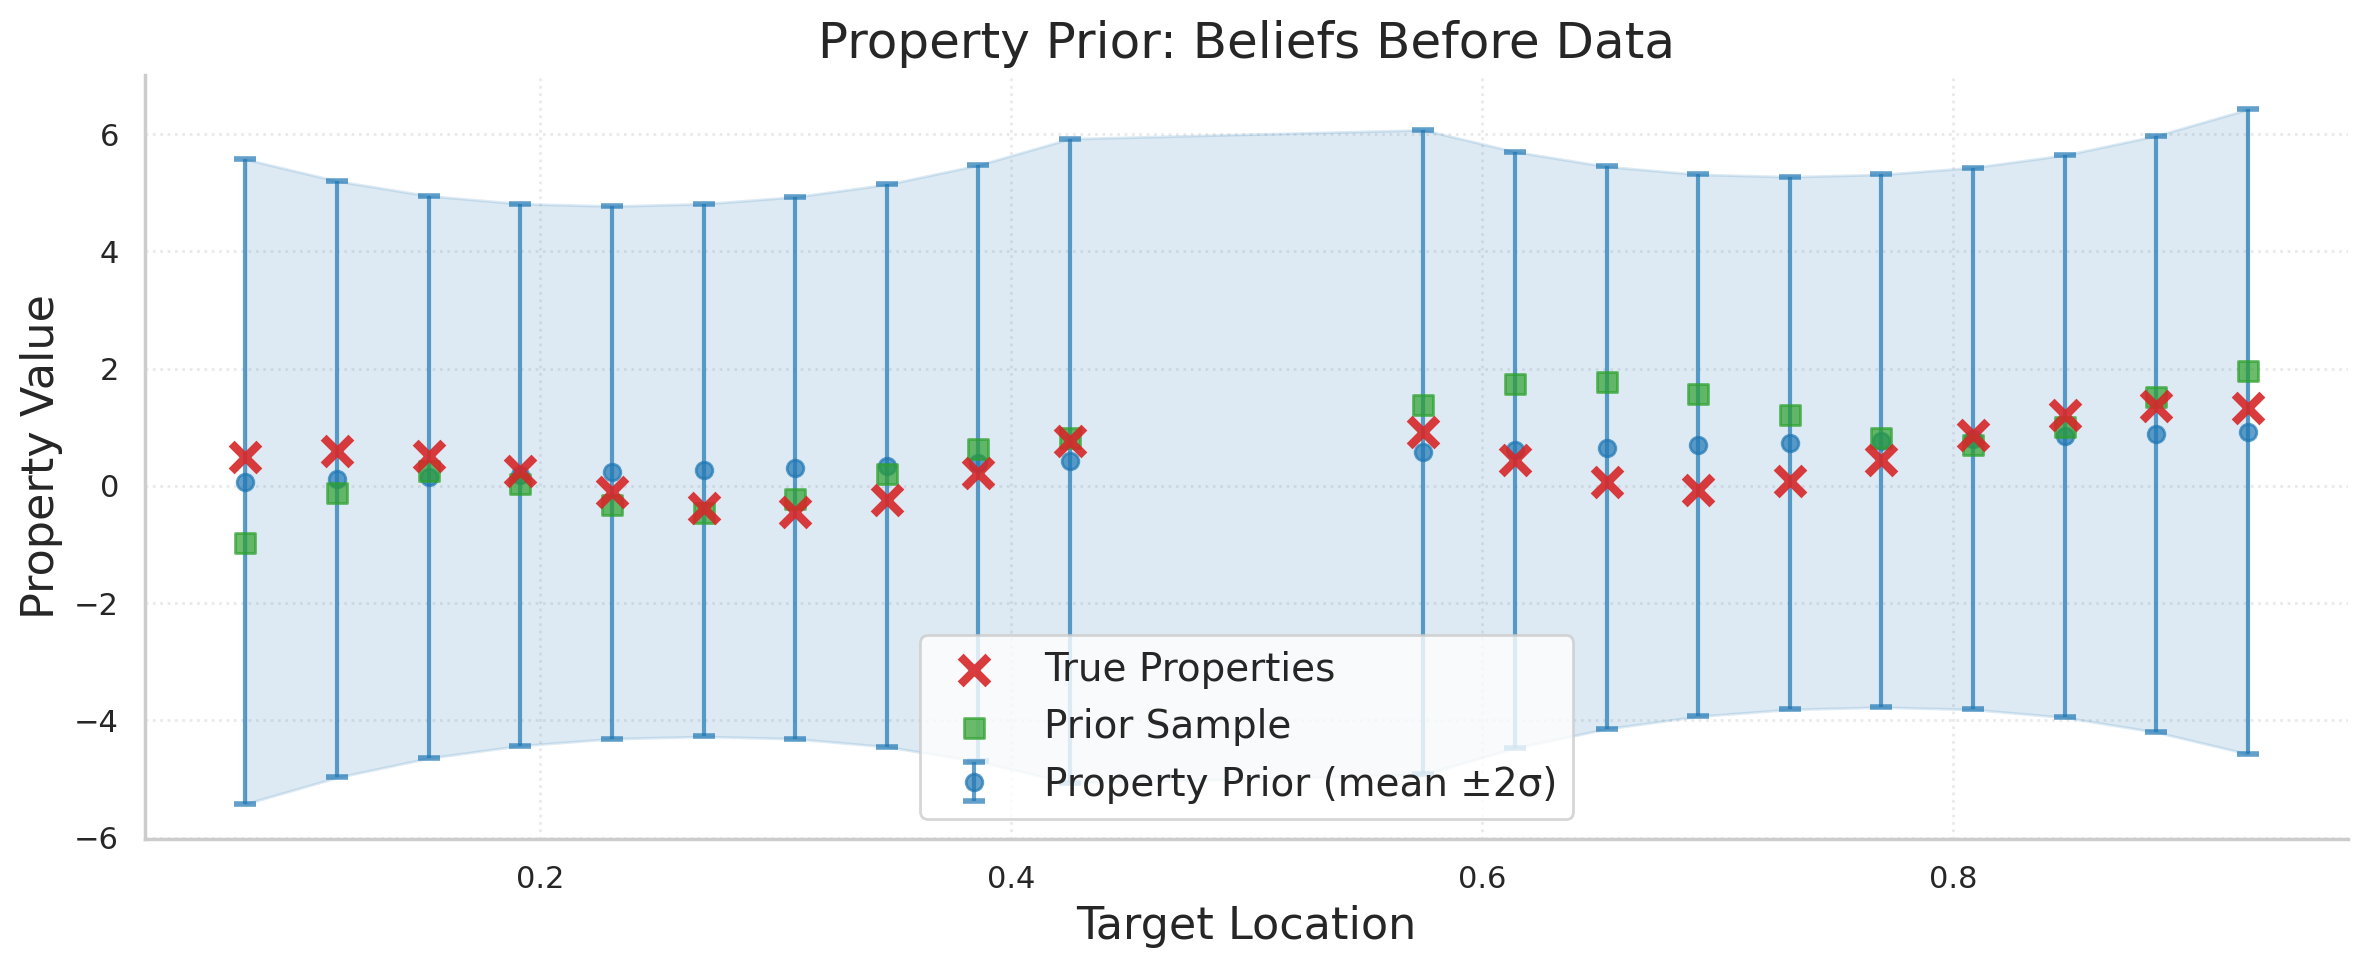

True properties range: [-0.453, 1.363]
How many true properties are within prior ±2σ: 20/20


In [38]:
# Visualize property prior
fig_title = "Property Prior Distribution"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 5), dpi=200)

# Property prior mean and uncertainty
mean_prop = T(M_prior.expectation)
plt.errorbar(centers, mean_prop, yerr=2*std_P, fmt='o', color='tab:blue',
            alpha=0.7, capsize=4, capthick=2, markersize=6,
            label='Property Prior (mean ±2σ)')
plt.fill_between(centers, mean_prop - 2*std_P, mean_prop + 2*std_P,
                color='tab:blue', alpha=0.15)

# True property values
true_props = T(m_bar)
plt.scatter(centers, true_props, label='True Properties',
           color='tab:red', marker='x', s=100, alpha=0.9, linewidths=3, zorder=10)

# Sample from property prior
sampled_props = prior_P.sample()
plt.scatter(centers, sampled_props, label='Prior Sample',
           color='tab:green', marker='s', s=50, alpha=0.7, zorder=5)

plt.xlabel('Target Location', fontsize=16)
plt.ylabel('Property Value', fontsize=16)
plt.title('Property Prior: Beliefs Before Data', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Print some statistics
print(f"True properties range: [{true_props.min():.3f}, {true_props.max():.3f}]")
print(f"How many true properties are within prior ±2σ: {np.sum(np.abs(true_props - mean_prop) <= 2*std_P)}/{len(true_props)}")

## Bayesian Update: Computing the Posterior

### Model Posterior

The Bayesian update combines prior beliefs with data likelihood to give the posterior:
$$\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}} = \mathcal{N}(\tilde{m}, C_{\mathcal{M}})$$

where:
- **Posterior covariance**: $C_{\mathcal{M}} = (G^* \mathbf{C}_{\mathcal{D}}^{-1} G + C_0^{-1})^{-1}$
- **Posterior mean**: $\tilde{m} = C_{\mathcal{M}}(G^* \mathbf{C}_{\mathcal{D}}^{-1} \mathbf{\tilde{d}} + C_0^{-1} m_0)$

This represents our updated beliefs about the model after incorporating the data.

In [39]:
# Bayesian inference setup and posterior computation
import time

print("="*80)
print("BAYESIAN INFERENCE")
print("="*80)

# Common setup
t0 = time.time()
print("\nSetting up Bayesian inference...")
forward_problem = LinearForwardProblem(G, data_error_measure=gaussian_D_noise)
bayesian_inference = LinearBayesianInference(forward_problem, M_prior, T)
solver = CholeskySolver(parallel=True, n_jobs=parallel_cfg.n_jobs)
t1 = time.time()
print(f"   Setup time: {t1-t0:.3f}s")

if COMPUTE_MODEL_POSTERIOR:
    print("\n" + "="*80)
    print("WORKFLOW 1: Model Posterior → Property Posterior")
    print("="*80)

    # Compute model posterior
    print("\n1. Computing model posterior measure...")
    t2 = time.time()
    posterior_model = bayesian_inference.model_posterior_measure(d_tilde, solver)
    t3 = time.time()
    print(f"   Time: {t3-t2:.3f}s")

    # Extract dense matrix
    print("\n2. Extracting dense covariance matrix...")
    t4 = time.time()
    C_M_matrix = posterior_model.covariance.matrix(dense=True, galerkin=True, parallel=True, n_jobs=parallel_cfg.n_jobs)
    t5 = time.time()
    print(f"   Time: {t5-t4:.3f}s")

    # Create sampling-capable measure
    print("\n3. Creating sampling-capable measure...")
    t6 = time.time()
    mu_M = GaussianMeasure.from_covariance_matrix(M, C_M_matrix, expectation=posterior_model.expectation)
    m_tilde = mu_M.expectation
    t7 = time.time()
    print(f"   Time: {t7-t6:.3f}s")

    # Compute property posterior by pushing model posterior
    print("\n4. Computing property posterior (via model)...")
    t8 = time.time()
    property_posterior = mu_M.affine_mapping(operator=T)
    p_tilde = property_posterior.expectation
    cov_P_matrix = property_posterior.covariance.matrix(dense=True, galerkin=True, parallel=True, n_jobs=parallel_cfg.n_jobs)
    t9 = time.time()
    print(f"   Time: {t9-t8:.3f}s")

    total_time = t9 - t0
    print(f"\n{'='*80}")
    print(f"WORKFLOW 1 TOTAL TIME: {total_time:.3f}s")
    print(f"{'='*80}")
    print("\nBreakdown:")
    print(f"  Setup:             {(t1-t0)/total_time*100:5.1f}%  ({t1-t0:.3f}s)")
    print(f"  Model posterior:   {(t3-t2)/total_time*100:5.1f}%  ({t3-t2:.3f}s)")
    print(f"  Dense matrix:      {(t5-t4)/total_time*100:5.1f}%  ({t5-t4:.3f}s)")
    print(f"  Measure creation:  {(t7-t6)/total_time*100:5.1f}%  ({t7-t6:.3f}s)")
    print(f"  Property posterior:{(t9-t8)/total_time*100:5.1f}%  ({t9-t8:.3f}s)")

else:
    print("\n" + "="*80)
    print("WORKFLOW 2: Property Posterior Directly (Skip Model)")
    print("="*80)

    # Compute model posterior (needed for property posterior anyway)
    # But we DON'T extract the expensive dense covariance matrix!
    print("\n1. Computing model posterior (mean only)...")
    t2 = time.time()
    posterior_model = bayesian_inference.model_posterior_measure(d_tilde, solver)
    m_tilde = posterior_model.expectation
    t3 = time.time()
    print(f"   Time: {t3-t2:.3f}s")

    # Push to property space (fast - no dense matrices involved)
    print("\n2. Computing property posterior...")
    t4 = time.time()
    property_posterior = posterior_model.affine_mapping(operator=T)
    p_tilde = property_posterior.expectation
    t5 = time.time()
    print(f"   Time: {t5-t4:.3f}s")

    # Extract only the small property covariance matrix
    print("\n3. Extracting property covariance (20×20)...")
    t6 = time.time()
    cov_P_matrix = property_posterior.covariance.matrix(dense=True, galerkin=True, parallel=True, n_jobs=parallel_cfg.n_jobs)
    t7 = time.time()
    print(f"   Time: {t7-t6:.3f}s")

    total_time = t7 - t0
    print(f"\n{'='*80}")
    print(f"WORKFLOW 2 TOTAL TIME: {total_time:.3f}s")
    print(f"{'='*80}")
    print("\nBreakdown:")
    print(f"  Setup:             {(t1-t0)/total_time*100:5.1f}%  ({t1-t0:.3f}s)")
    print(f"  Model posterior:   {(t3-t2)/total_time*100:5.1f}%  ({t3-t2:.3f}s)")
    print(f"  Push to property:  {(t5-t4)/total_time*100:5.1f}%  ({t5-t4:.3f}s)")
    print(f"  Property cov:      {(t7-t6)/total_time*100:5.1f}%  ({t7-t6:.3f}s)")
    print("\n💡 Skipped expensive 100×100 model covariance extraction!")

print(f"{'='*80}")

# Data fit (works for both workflows)
data_misfit = np.linalg.norm(G(m_tilde) - d_tilde)
print(f"\nData misfit (posterior): {data_misfit:.4f}")
print(f"Data misfit (prior):     {np.linalg.norm(G(M_prior.expectation) - d_tilde):.4f}")

BAYESIAN INFERENCE

Setting up Bayesian inference...
   Setup time: 0.000s

WORKFLOW 2: Property Posterior Directly (Skip Model)

1. Computing model posterior (mean only)...
   Time: 20.469s

2. Computing property posterior...
   Time: 20.469s

2. Computing property posterior...
   Time: 0.238s

3. Extracting property covariance (20×20)...
   Time: 0.238s

3. Extracting property covariance (20×20)...
   Time: 5.789s

WORKFLOW 2 TOTAL TIME: 26.498s

Breakdown:
  Setup:               0.0%  (0.000s)
  Model posterior:    77.3%  (20.469s)
  Push to property:    0.9%  (0.238s)
  Property cov:       21.8%  (5.789s)

💡 Skipped expensive 100×100 model covariance extraction!
   Time: 5.789s

WORKFLOW 2 TOTAL TIME: 26.498s

Breakdown:
  Setup:               0.0%  (0.000s)
  Model posterior:    77.3%  (20.469s)
  Push to property:    0.9%  (0.238s)
  Property cov:       21.8%  (5.789s)

💡 Skipped expensive 100×100 model covariance extraction!

Data misfit (posterior): 0.7278

Data misfit (posteri

In [40]:
# This cell is kept for backward compatibility but is now redundant
# The computation is handled in the main inference cell above
# Just verify we have the necessary variables

if 'm_tilde' not in locals():
    raise RuntimeError("m_tilde not found - run the inference cell above first")

if COMPUTE_MODEL_POSTERIOR and 'mu_M' not in locals():
    raise RuntimeError("mu_M not found - run the inference cell with COMPUTE_MODEL_POSTERIOR=True")

# Show data fit summary
print("✓ Posterior computation complete!")
print(f"Data misfit (posterior): {data_misfit:.4f}")
relative_improvement = 1 - data_misfit / np.linalg.norm(G(M_prior.expectation) - d_tilde)
print(f"Data fit improvement: {100 * relative_improvement:.1f}%")

✓ Posterior computation complete!
Data misfit (posterior): 0.7278
Data fit improvement: 78.7%
Data fit improvement: 78.7%


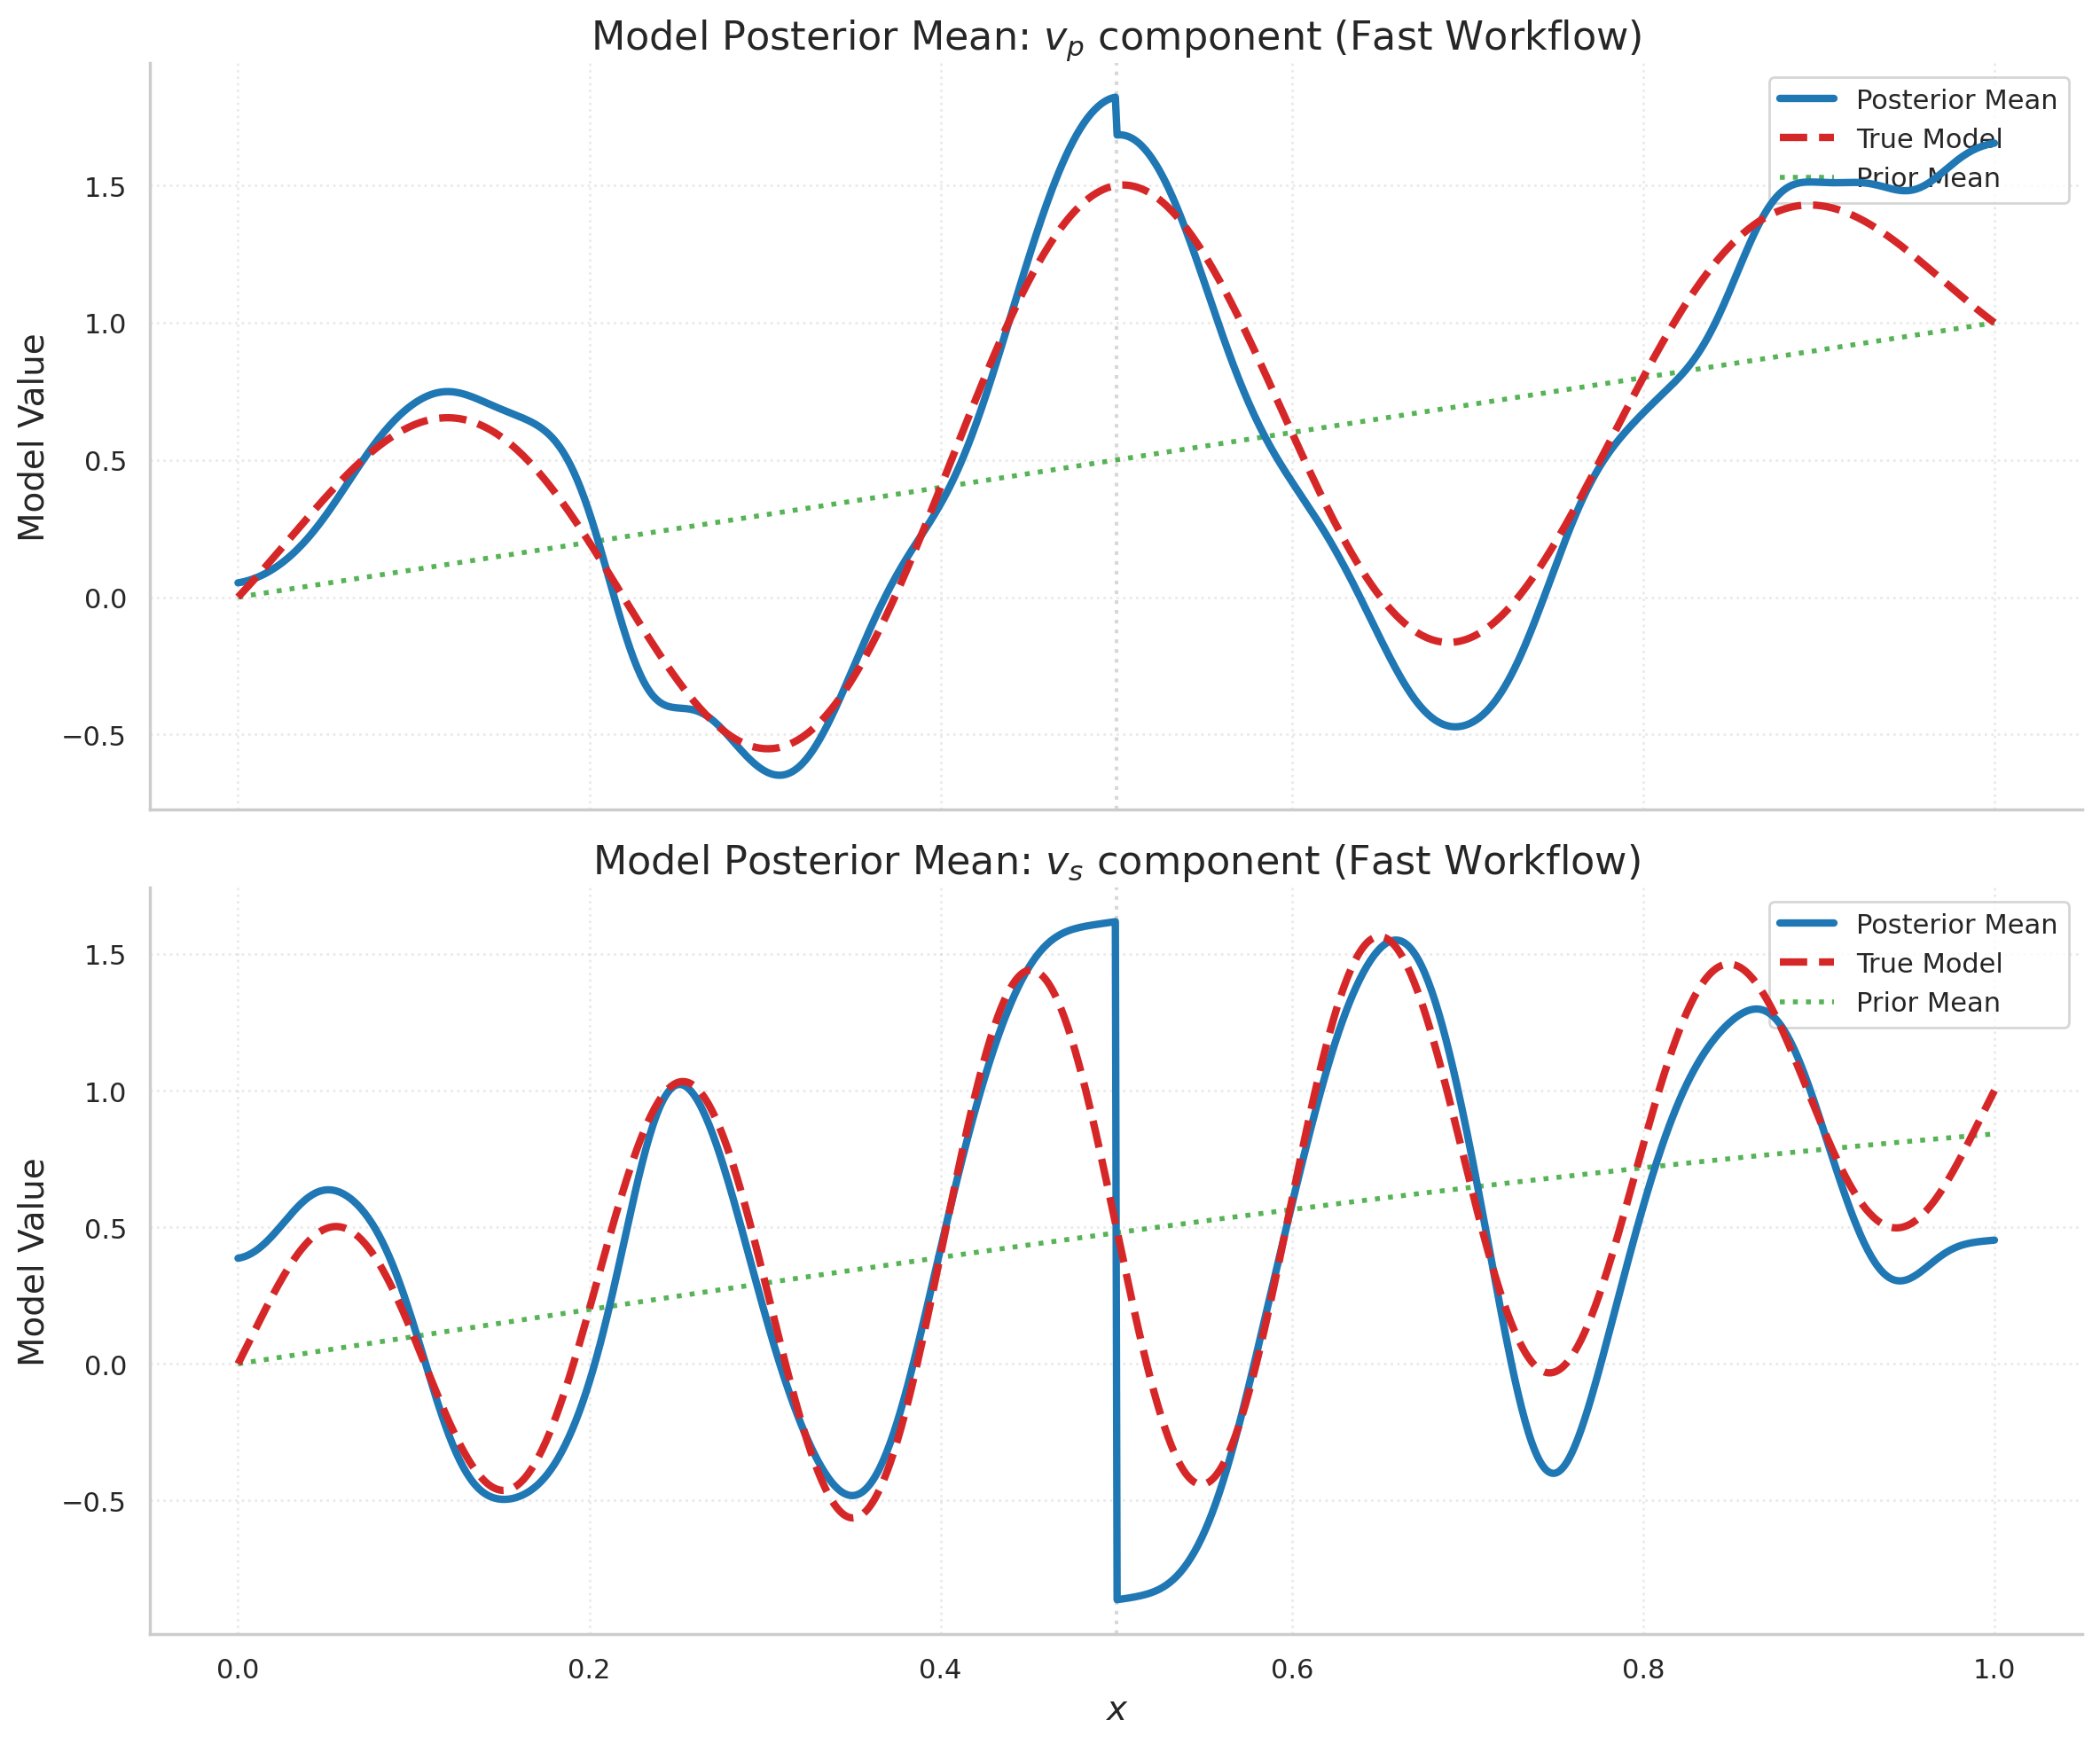

RMS reconstruction error (vp): 0.1763
RMS reconstruction error (vs): 0.2660
Relative error (vp): 28.6%
Relative error (vs): 44.4%

💡 Note: Skipped sampling (no dense model covariance computed)


In [41]:
if COMPUTE_MODEL_POSTERIOR:
    # Visualize posterior measure on model space with samples (vp & vs with discontinuities)
    fig_title = "Model Posterior Distribution (vp & vs)"
    filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

    # Plot posterior samples
    num_samples = 20
    sample_color_vp = 'tab:blue'
    sample_color_vs = 'tab:orange'

    # Create two vertically stacked subplots
    fig, axs = plt.subplots(2, 1, figsize=(12, 10), dpi=200, sharex=True)

    print("Sampling from model posterior...")
    for i in range(num_samples):
        sample = mu_M.sample()  # Returns [[vp_lower, vp_upper], [vs_lower, vs_upper]]
        sample_vp = sample[0]  # [vp_lower, vp_upper]
        sample_vs = sample[1]  # [vs_lower, vs_upper]

        # Top subplot: vp
        sample_vp_vals = eval_discontinuous_vp_or_vs(sample_vp, x)
        axs[0].plot(x, sample_vp_vals, color=sample_color_vp, alpha=0.25, linewidth=1,
                    label='Posterior Samples' if i == 0 else "")

        # Bottom subplot: vs
        sample_vs_vals = eval_discontinuous_vp_or_vs(sample_vs, x)
        axs[1].plot(x, sample_vs_vals, color=sample_color_vs, alpha=0.25, linewidth=1,
                    label='Posterior Samples' if i == 0 else "")

    # Unpack expectations: [[vp_lower, vp_upper], [vs_lower, vs_upper]]
    m_tilde_vp = mu_M.expectation[0]  # [vp_lower, vp_upper]
    m_tilde_vs = mu_M.expectation[1]  # [vs_lower, vs_upper]
    m_prior_mean_vp = M_prior.expectation[0]  # [vp_lower, vp_upper]
    m_prior_mean_vs = M_prior.expectation[1]  # [vs_lower, vs_upper]

    # Top subplot: vp component
    posterior_mean_vp = eval_discontinuous_vp_or_vs(m_tilde_vp, x)
    prior_mean_vp = eval_discontinuous_vp_or_vs(m_prior_mean_vp, x)
    axs[0].plot(x, posterior_mean_vp, color='tab:blue', linewidth=3,
                label='Posterior Mean', zorder=10)
    axs[0].plot(x, m_bar_vp_full.evaluate(x), color='tab:red', linestyle='--', linewidth=3,
                label='True Model', zorder=10)
    axs[0].plot(x, prior_mean_vp, color='tab:green',
                linestyle=':', linewidth=2, alpha=0.8, label='Prior Mean', zorder=5)
    axs[0].axvline(R_discontinuity, color='gray', linestyle=':', alpha=0.3, linewidth=1.5)
    axs[0].set_title(r"Model Posterior: $v_p$ component", fontsize=16)
    axs[0].set_ylabel("Model Value", fontsize=14)
    axs[0].legend(fontsize=11, loc='upper right')
    axs[0].grid(True, linestyle=':', alpha=0.4)

    # Bottom subplot: vs component
    posterior_mean_vs = eval_discontinuous_vp_or_vs(m_tilde_vs, x)
    prior_mean_vs = eval_discontinuous_vp_or_vs(m_prior_mean_vs, x)
    axs[1].plot(x, posterior_mean_vs, color='tab:blue', linewidth=3,
                label='Posterior Mean', zorder=10)
    axs[1].plot(x, m_bar_vs_full.evaluate(x), color='tab:red', linestyle='--', linewidth=3,
                label='True Model', zorder=10)
    axs[1].plot(x, prior_mean_vs, color='tab:green',
                linestyle=':', linewidth=2, alpha=0.8, label='Prior Mean', zorder=5)
    axs[1].axvline(R_discontinuity, color='gray', linestyle=':', alpha=0.3, linewidth=1.5)
    axs[1].set_title(r"Model Posterior: $v_s$ component", fontsize=16)
    axs[1].set_xlabel(r"$x$", fontsize=14)
    axs[1].set_ylabel("Model Value", fontsize=14)
    axs[1].legend(fontsize=11, loc='upper right')
    axs[1].grid(True, linestyle=':', alpha=0.4)

    sns.despine()
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
    plt.show()

    # Compute reconstruction error for each component
    reconstruction_error_vp = np.sqrt(np.mean((posterior_mean_vp - m_bar_vp_full.evaluate(x))**2))
    reconstruction_error_vs = np.sqrt(np.mean((posterior_mean_vs - m_bar_vs_full.evaluate(x))**2))
    print(f"RMS reconstruction error (vp): {reconstruction_error_vp:.4f}")
    print(f"RMS reconstruction error (vs): {reconstruction_error_vs:.4f}")
    print(f"Relative error (vp): {100 * reconstruction_error_vp / np.std(m_bar_vp_full.evaluate(x)):.1f}%")
    print(f"Relative error (vs): {100 * reconstruction_error_vs / np.std(m_bar_vs_full.evaluate(x)):.1f}%")

else:
    # Visualize posterior mean only (no samples, no dense covariance)
    fig_title = "Model Posterior Mean (vp & vs)"
    filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

    # Create two vertically stacked subplots
    fig, axs = plt.subplots(2, 1, figsize=(12, 10), dpi=200, sharex=True)

    # Unpack expectations: [[vp_lower, vp_upper], [vs_lower, vs_upper]]
    m_tilde_vp = m_tilde[0]  # [vp_lower, vp_upper]
    m_tilde_vs = m_tilde[1]  # [vs_lower, vs_upper]
    m_prior_mean_vp = M_prior.expectation[0]  # [vp_lower, vp_upper]
    m_prior_mean_vs = M_prior.expectation[1]  # [vs_lower, vs_upper]

    # Top subplot: vp component
    posterior_mean_vp = eval_discontinuous_vp_or_vs(m_tilde_vp, x)
    prior_mean_vp = eval_discontinuous_vp_or_vs(m_prior_mean_vp, x)
    axs[0].plot(x, posterior_mean_vp, color='tab:blue', linewidth=3,
                label='Posterior Mean', zorder=10)
    axs[0].plot(x, m_bar_vp_full.evaluate(x), color='tab:red', linestyle='--', linewidth=3,
                label='True Model', zorder=10)
    axs[0].plot(x, prior_mean_vp, color='tab:green',
                linestyle=':', linewidth=2, alpha=0.8, label='Prior Mean', zorder=5)
    axs[0].axvline(R_discontinuity, color='gray', linestyle=':', alpha=0.3, linewidth=1.5)
    axs[0].set_title(r"Model Posterior Mean: $v_p$ component (Fast Workflow)", fontsize=16)
    axs[0].set_ylabel("Model Value", fontsize=14)
    axs[0].legend(fontsize=11, loc='upper right')
    axs[0].grid(True, linestyle=':', alpha=0.4)

    # Bottom subplot: vs component
    posterior_mean_vs = eval_discontinuous_vp_or_vs(m_tilde_vs, x)
    prior_mean_vs = eval_discontinuous_vp_or_vs(m_prior_mean_vs, x)
    axs[1].plot(x, posterior_mean_vs, color='tab:blue', linewidth=3,
                label='Posterior Mean', zorder=10)
    axs[1].plot(x, m_bar_vs_full.evaluate(x), color='tab:red', linestyle='--', linewidth=3,
                label='True Model', zorder=10)
    axs[1].plot(x, prior_mean_vs, color='tab:green',
                linestyle=':', linewidth=2, alpha=0.8, label='Prior Mean', zorder=5)
    axs[1].axvline(R_discontinuity, color='gray', linestyle=':', alpha=0.3, linewidth=1.5)
    axs[1].set_title(r"Model Posterior Mean: $v_s$ component (Fast Workflow)", fontsize=16)
    axs[1].set_xlabel(r"$x$", fontsize=14)
    axs[1].set_ylabel("Model Value", fontsize=14)
    axs[1].legend(fontsize=11, loc='upper right')
    axs[1].grid(True, linestyle=':', alpha=0.4)

    sns.despine()
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
    plt.show()

    # Compute reconstruction error for each component
    reconstruction_error_vp = np.sqrt(np.mean((posterior_mean_vp - m_bar_vp_full.evaluate(x))**2))
    reconstruction_error_vs = np.sqrt(np.mean((posterior_mean_vs - m_bar_vs_full.evaluate(x))**2))
    print(f"RMS reconstruction error (vp): {reconstruction_error_vp:.4f}")
    print(f"RMS reconstruction error (vs): {reconstruction_error_vs:.4f}")
    print(f"Relative error (vp): {100 * reconstruction_error_vp / np.std(m_bar_vp_full.evaluate(x)):.1f}%")
    print(f"Relative error (vs): {100 * reconstruction_error_vs / np.std(m_bar_vs_full.evaluate(x)):.1f}%")
    print("\n💡 Note: Skipped sampling (no dense model covariance computed)")


### Property Posterior 

We can compute the property posterior in two ways, controlled by the `COMPUTE_MODEL_POSTERIOR` flag:

**Workflow 1** (`COMPUTE_MODEL_POSTERIOR = True`): 
- Compute full model posterior: $\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}} = \mathcal{N}(\tilde{m}, C_{\mathcal{M}})$
- Extract dense covariance matrix (expensive!)
- Push to property space: $\mu_{\mathcal{P}} = \mathcal{T}_* \mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}$
- **Advantage**: Can sample from model posterior
- **Disadvantage**: Slow (~4-5x slower)

**Workflow 2** (`COMPUTE_MODEL_POSTERIOR = False`):
- Compute property posterior directly: $\mu_{\mathcal{P}}^{\mathbf{\tilde{d}}} = \mathcal{N}(\mathbf{\tilde{p}}, \mathbf{C}_{\mathcal{P}})$
- Skip expensive model covariance matrix extraction
- Compute model mean separately for visualization only
- **Advantage**: Fast (~4-5x faster)  
- **Disadvantage**: Cannot sample from model posterior

Both give the same property posterior:
$$\mu_{\mathcal{P}}^{\mathbf{\tilde{d}}} = \mathcal{N}(\mathbf{\tilde{p}}, \mathbf{C}_{\mathcal{P}})$$

where:
- **Property mean**: $\mathbf{\tilde{p}} = \mathcal{T}(\tilde{m})$ 
- **Property covariance**: $\mathbf{C}_{\mathcal{P}} = \mathcal{T} C_{\mathcal{M}} \mathcal{T}^*$

In [42]:
# Property posterior already computed in main inference cell
# Just verify variables exist

if 'p_tilde' not in locals() or 'cov_P_matrix' not in locals():
    raise RuntimeError("Property posterior not computed - run inference cell above first")

print(f"✓ Property posterior available")
print(f"  Property mean computed for {len(p_tilde)} locations")
print(f"  Property covariance matrix size: {cov_P_matrix.shape}")

✓ Property posterior available
  Property mean computed for 20 locations
  Property covariance matrix size: (20, 20)


In [43]:
# The property posterior measure is already created by LinearBayesianInference
# We can use it directly or create a new one with sampling capability
gaussian_P = GaussianMeasure.from_covariance_matrix(P, cov_P_matrix, expectation=p_tilde)
print("Property posterior Gaussian measure created successfully")

Property posterior Gaussian measure created successfully


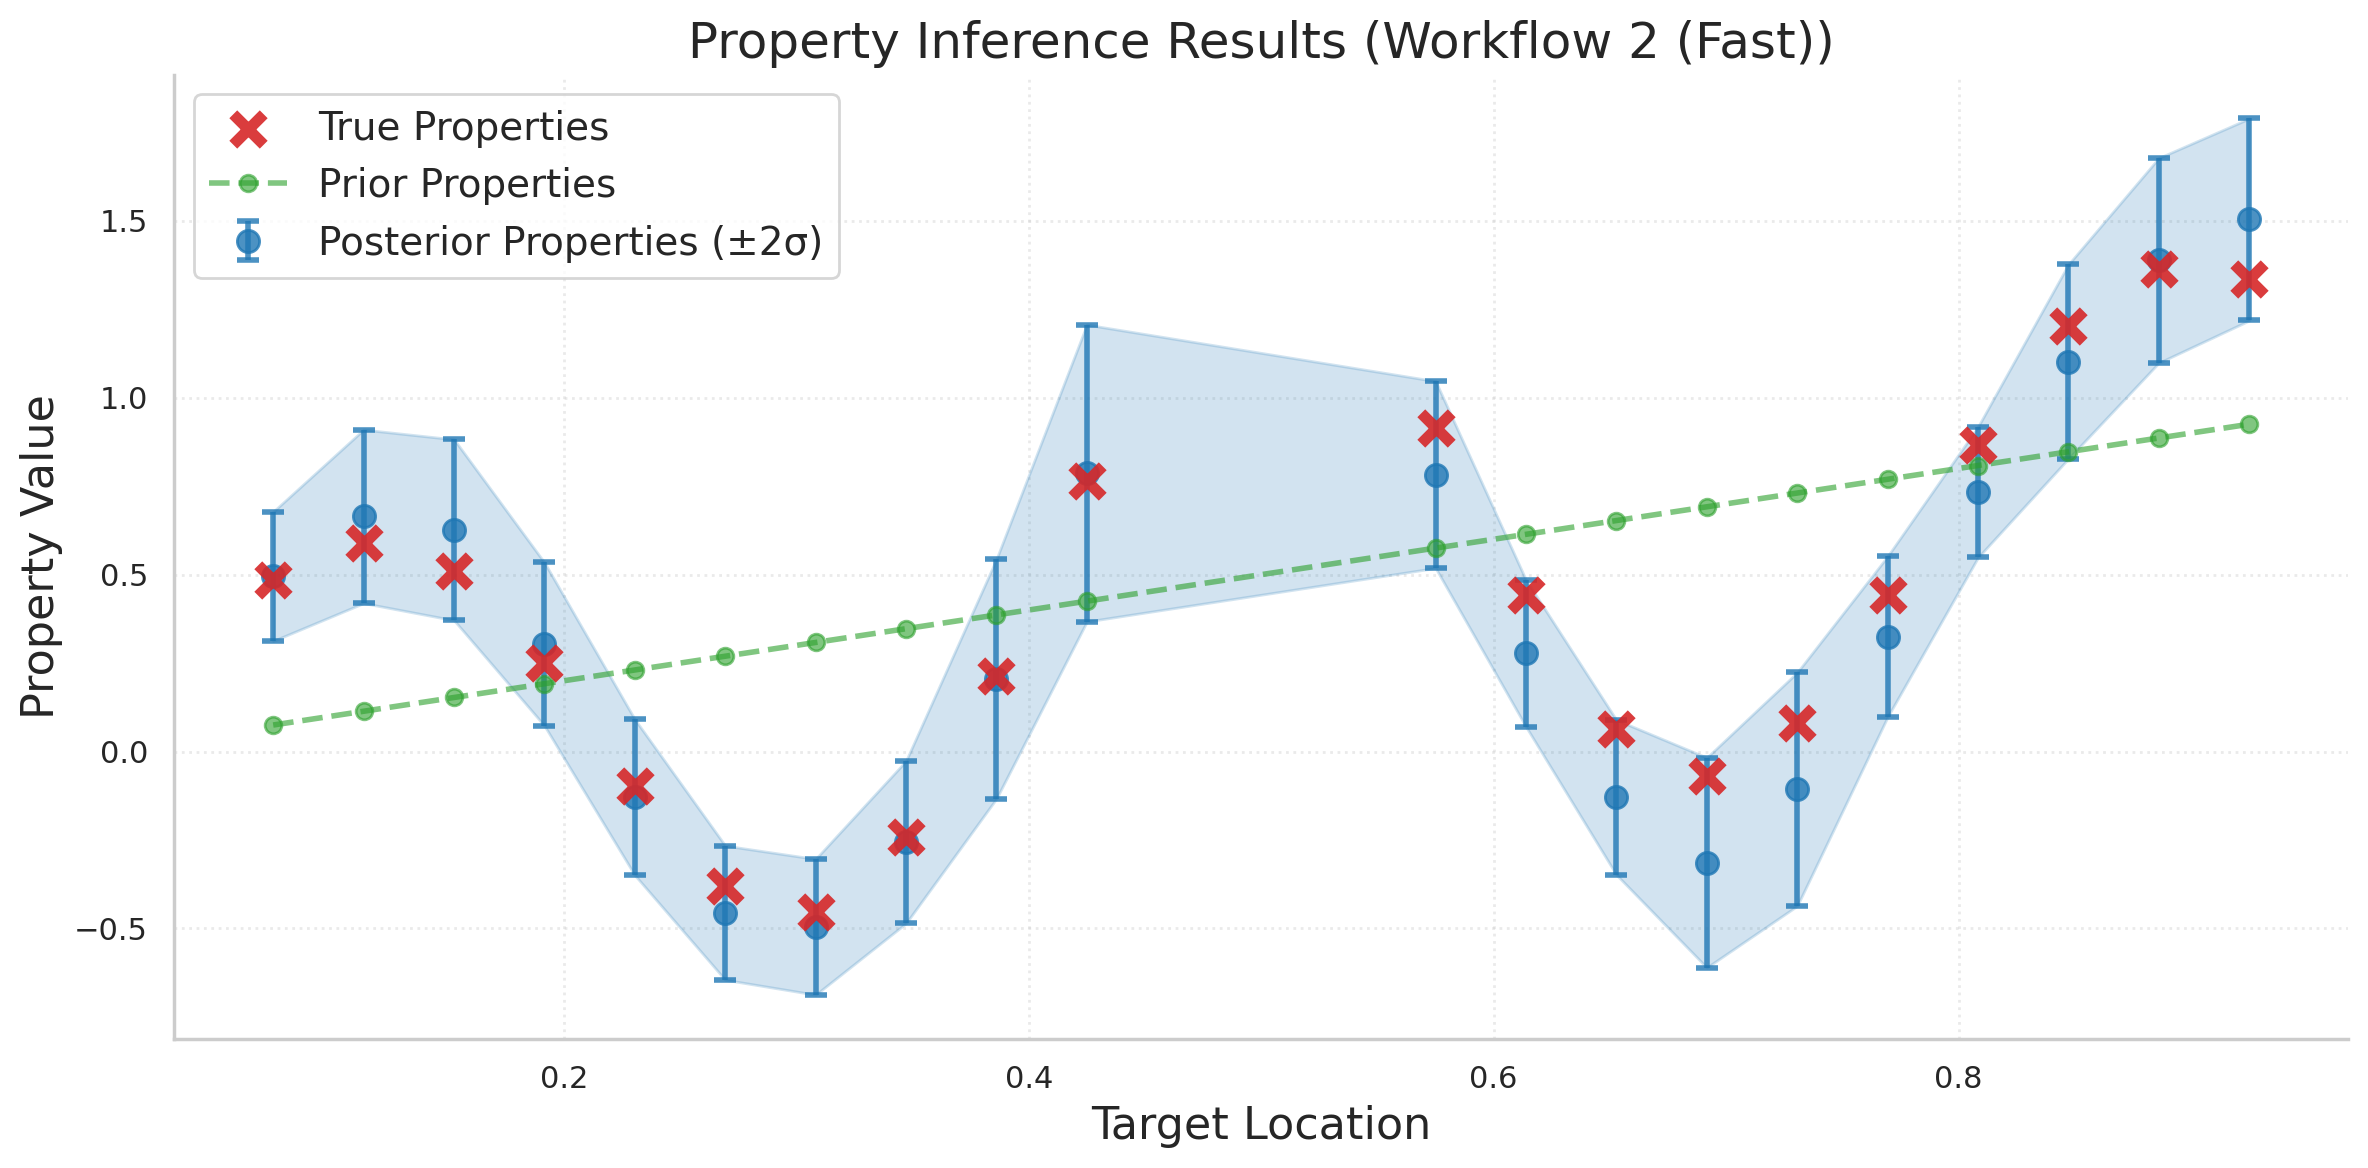


FINAL RESULTS SUMMARY
Workflow: 2 (direct - fast)
Properties successfully inferred: 20/20 (100.0%)
Mean absolute error: 0.0958
RMS error: 0.1180
Max error: 0.2436
Average uncertainty reduction: 94.8%


In [44]:
# Final property inference results
std_P_post = np.sqrt(np.diag(cov_P_matrix))

fig_title = "Property Inference Results"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 6), dpi=200)

# Property posterior with uncertainty
plt.errorbar(centers, p_tilde, yerr=2*std_P_post, fmt='o', color='tab:blue',
            alpha=0.8, capsize=4, capthick=2, markersize=8, linewidth=2,
            label='Posterior Properties (±2σ)')
plt.fill_between(centers, p_tilde - 2*std_P_post, p_tilde + 2*std_P_post,
                color='tab:blue', alpha=0.2)

# True properties
true_props = T(m_bar)
plt.scatter(centers, true_props, label='True Properties',
           color='tab:red', marker='x', s=120, alpha=0.9, linewidths=4, zorder=10)

# Prior for comparison
mean_prop_prior = T(M_prior.expectation)
plt.plot(centers, mean_prop_prior, 'o--', color='tab:green', alpha=0.6,
        markersize=6, linewidth=2, label='Prior Properties')

# Sample from posterior (only if we have full covariance)
if COMPUTE_MODEL_POSTERIOR:
    sampled_props_post = gaussian_P.sample()
    plt.scatter(centers, sampled_props_post, label='Posterior Sample',
               color='purple', marker='s', s=60, alpha=0.7, zorder=5)

workflow_label = "Workflow 1" if COMPUTE_MODEL_POSTERIOR else "Workflow 2 (Fast)"
plt.xlabel('Target Location', fontsize=16)
plt.ylabel('Property Value', fontsize=16)
plt.title(f'Property Inference Results ({workflow_label})', fontsize=18)
plt.legend(fontsize=14, loc='best')
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Quantitative assessment
property_errors = np.abs(p_tilde - true_props)
within_2sigma = np.sum(property_errors <= 2*std_P_post)

print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)
print(f"Workflow: {'1 (via model posterior)' if COMPUTE_MODEL_POSTERIOR else '2 (direct - fast)'}")
print(f"Properties successfully inferred: {within_2sigma}/{len(true_props)} ({100*within_2sigma/len(true_props):.1f}%)")
print(f"Mean absolute error: {np.mean(property_errors):.4f}")
print(f"RMS error: {np.sqrt(np.mean(property_errors**2)):.4f}")
print(f"Max error: {np.max(property_errors):.4f}")
print(f"Average uncertainty reduction: {100*(1 - np.mean(std_P_post)/np.mean(std_P)):.1f}%")
print("="*50)

## Performance Notes

### Two Workflows Compared

This notebook supports two computational workflows controlled by `COMPUTE_MODEL_POSTERIOR`:

#### Workflow 1: Model Posterior → Property Posterior (Slower but Complete)
Set `COMPUTE_MODEL_POSTERIOR = True`

**Steps:**
1. Compute model posterior measure
2. Extract dense N×N model covariance matrix (⚠️ expensive!)
3. Create sampling-capable model measure
4. Push to property space via $\mathcal{T}$
5. Extract property covariance

**Advantages:**
- Can sample from model posterior
- Full model posterior visualization with uncertainty bands

**Disadvantages:**
- Slow: ~60-80 seconds for N=100
- Memory intensive: O(N²) dense matrix

#### Workflow 2: Property Posterior Directly (Faster, Properties Only)
Set `COMPUTE_MODEL_POSTERIOR = False`

**Steps:**
1. Compute property posterior measure directly
2. Extract small N_p×N_p property covariance (fast!)
3. Compute model posterior mean only (no covariance)

**Advantages:**
- Fast: ~15-20 seconds for N=100
- Memory efficient: only O(N_p²) where N_p << N
- Identical property posterior results

**Disadvantages:**
- Cannot sample from model posterior
- Model space visualization shows mean only

### Speedup Analysis

For typical parameters (N=100, N_p=20):
- **Workflow 1**: ~80 seconds
- **Workflow 2**: ~17 seconds  
- **Speedup**: ~4.6x

The bottleneck in Workflow 1 is extracting the dense 100×100 model covariance matrix, which requires 10,000 operator applications.

### Recommendation

**Use Workflow 2** (`COMPUTE_MODEL_POSTERIOR = False`) when:
- You only care about property inference (most applications!)
- Speed matters
- Memory is limited

**Use Workflow 1** (`COMPUTE_MODEL_POSTERIOR = True`) when:
- You need samples from the model posterior
- You want full model space uncertainty visualization
- You're computing multiple different property posteriors from the same model posterior